In [1]:
import pandas as pd
import requests
import io
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import scienceplots

plt.style.use('science')

ASSETS = "../assets/"
DATA = "../data/"
LINE_COLOR='#1B4244'
LINE_COLOR_RED='#FB4142'
LINE_COLOR_BLUE='#3F86BC'
LINE_COLOR_GREEN='#006601'


In [2]:
miner_efficiency = pd.read_csv(DATA+'miner_efficiency.csv', index_col=0)
miner_efficiency.index = pd.to_datetime(miner_efficiency.index)
electricity_price = pd.read_csv(DATA+'electricity_price.csv',index_col=0)
electricity_price.index = pd.to_datetime(electricity_price.index)
onchain = pd.read_csv(DATA+'onchain.csv', index_col=0)
onchain.index = pd.to_datetime(onchain.index)
total_bitcoins = pd.read_csv(DATA+'total_bitcoins.csv', index_col=0)
total_bitcoins.index = pd.to_datetime(total_bitcoins.index)
electricity_price = electricity_price[~electricity_price.index.duplicated(keep='first')]
simulated_bitcoins = pd.read_csv(DATA+'simulated_bitcoins.csv', index_col=0)
simulated_bitcoins.index = pd.to_datetime(simulated_bitcoins.index)

In [3]:
efficiency_df=miner_efficiency[["Efficiency (J/TH)"]]
last_efficiency = miner_efficiency['Efficiency (J/TH)'].iloc[-1]
efficiency_df = pd.concat([efficiency_df,(pd.DataFrame({ 'Efficiency (J/TH)': last_efficiency }, index=[onchain.index[-1]]))])
efficiency_df=efficiency_df.resample('D').interpolate('linear').resample('W-SUN').mean()

In [4]:
electricity_price = electricity_price[["COM","IND","CPI"]].resample('D').interpolate('linear').resample('W-SUN').mean().rolling(window=3*4).mean()

In [5]:
df=efficiency_df.join(onchain)

In [6]:
df["Power Consumption (Watt)"]=(df["hash_rate"]*df['Efficiency (J/TH)'].rolling(int(52.1429*1.5),min_periods=1).mean()).rolling(4,min_periods=1).mean()
df=df[~np.isnan(df["Power Consumption (Watt)"])]

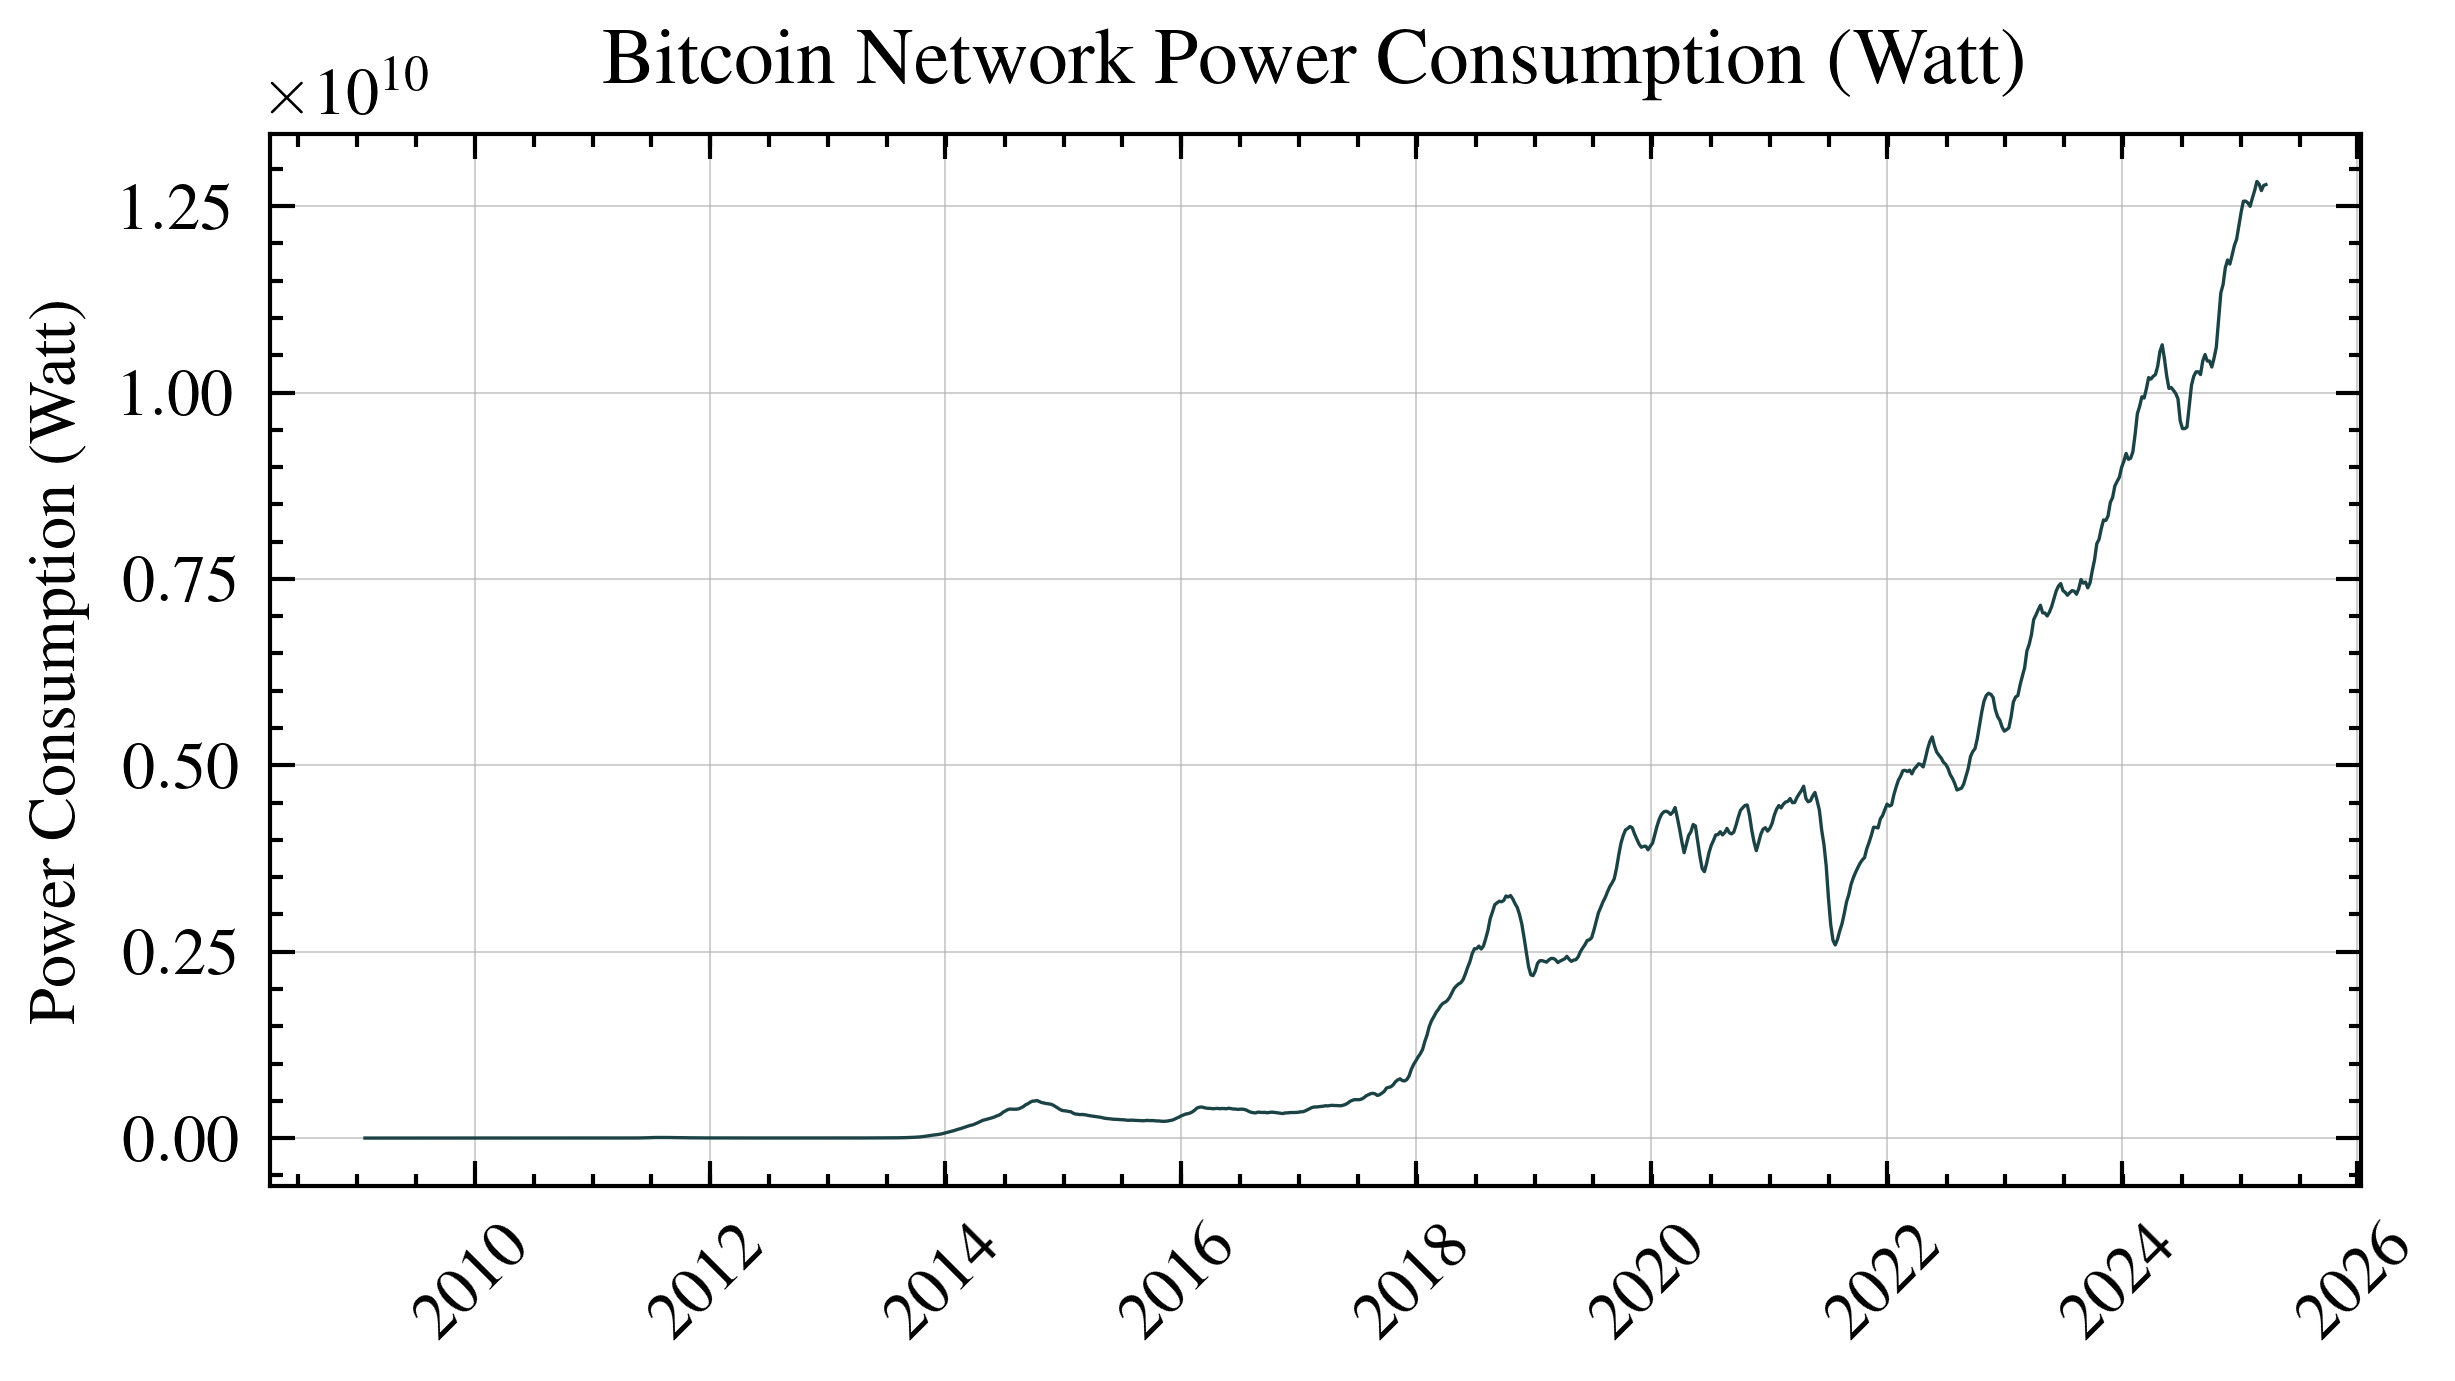

In [7]:
with plt.style.context(['science','ieee']):
    plt.figure(figsize=(4, 2.25))
    plt.grid(True, linestyle='-', alpha=0.7, linewidth=0.2)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.plot(df.index, df["Power Consumption (Watt)"], linestyle='-', linewidth=0.4, color=LINE_COLOR)
    plt.ylabel('Power Consumption (Watt)')
    plt.title('Bitcoin Network Power Consumption (Watt)')
    plt.savefig(ASSETS+'powerconsumption1.png')
    plt.show()

In [8]:
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit

def logistic(t, L, k, x0, offset):
    """
    A logistic (sigmoid) function:
        y(t) = offset + L / (1 + e^(-k*(t - x0)))
    where:
        L      = curve's maximum height above 'offset'
        k      = steepness of the curve
        x0     = the time value of the sigmoid's midpoint
        offset = vertical shift (minimum value)
    """
    return offset + L / (1.0 + np.exp(-k * (t - x0)))

def approximate_sigmoid(ts: pd.Series, L, forecast_days: int = 30) -> pd.Series:
    """
    Fit a logistic curve to the known part of the time series,
    then forecast forward 'forecast_days' days using the fitted curve.
    
    Parameters
    ----------
    ts : pd.Series
        A Pandas Series with a DatetimeIndex.
    forecast_days : int
        Number of days to forecast into the future.

    Returns
    -------
    pd.Series
        A Series containing the fitted values for the historical period
        plus the forecasted values for the future period.
    """
    # Ensure the Series is sorted by date
    ts = ts.sort_index()
    
    # Convert DatetimeIndex to a numeric scale: days from the start
    start_date = ts.index[0]
    x_known = (ts.index - start_date).days.values.astype(float)
    
    # Known values
    y_known = ts.values.astype(float)
    
    # Initial guesses for L, k, x0, offset (try to set them sensibly)
    k_init = 0.1                              # guess for steepness
    x0_init = x_known.mean()                  # midpoint near center of the known data
    offset_init = y_known.min()               # minimal value as offset
    
    initial_guesses = [k_init, x0_init, offset_init]

    func = lambda x, k, x0, offset: logistic(x, L, k, x0, offset)

    # Fit the logistic function to the known data
    popt, pcov = curve_fit(func, x_known, y_known, p0=initial_guesses,maxfev=10_000)
    
    # Extract fitted parameters
    k_fit, x0_fit, offset_fit = popt
    print(k_fit, x0_fit, offset_fit)
    
    # Create a combined time range: known + forecast
    last_date = ts.index[-1]
    future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1),
                                 periods=forecast_days,
                                 freq='D')
    
    all_dates = ts.index.union(future_dates)
    
    # Convert all times to numeric for forecasting
    x_all = (all_dates - start_date).days.values.astype(float)
    
    # Apply the fitted logistic function to the entire date range
    y_all = func(x_all,  k_fit, x0_fit, offset_fit)
    
    # Return as a Pandas Series
    fitted_forecast = pd.Series(data=y_all, index=all_dates)
    return fitted_forecast

In [9]:
MAX_ENERGY = df["Power Consumption (Watt)"][-1]*1.5
forecast_series = approximate_sigmoid(df["Power Consumption (Watt)"], MAX_ENERGY, forecast_days=365*120)
last = df["Power Consumption (Watt)"][df.index[-1]]
last_date = df.index[-1]

0.0011080290563405082 5591.550378432786 -65558787.36291795


C:\Users\pkapl\AppData\Local\Temp\ipykernel_16236\4036602926.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  MAX_ENERGY = df["Power Consumption (Watt)"][-1]*1.5


In [10]:
delta = forecast_series.iloc[(forecast_series-last).abs().argsort()[:1]].index-last_date
forecast_series=forecast_series.shift(-delta.days[0])[last_date:]

In [11]:
df["Power Consumption (Watt)"].to_csv('power_consumption.csv')

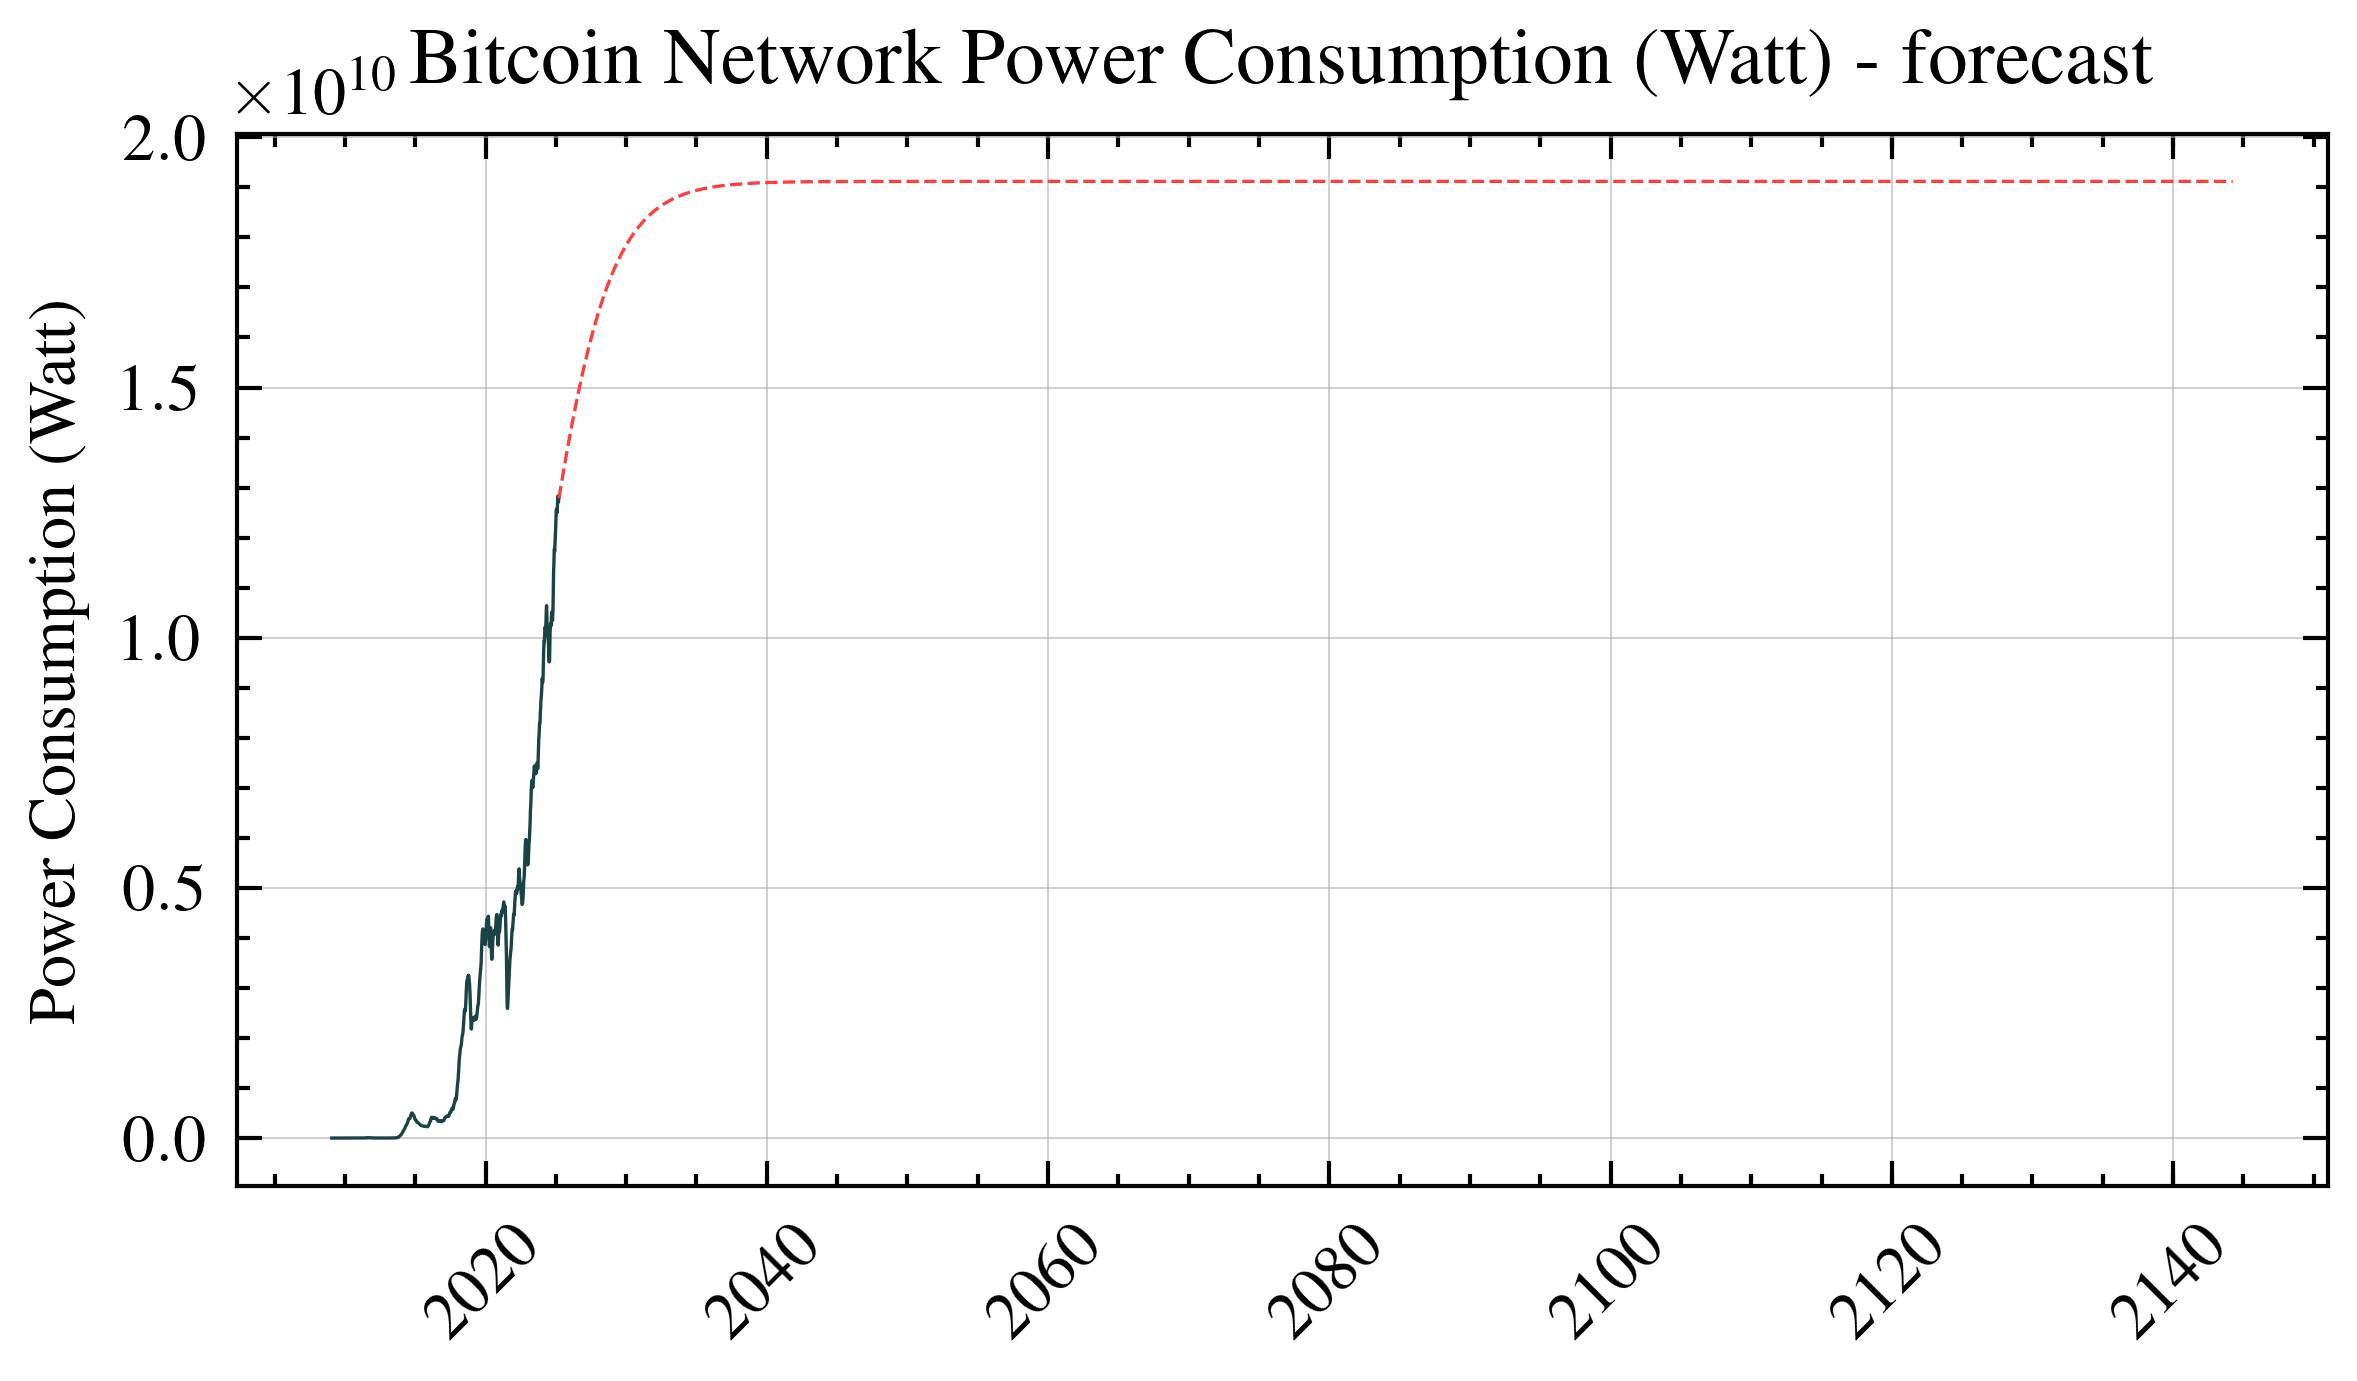

In [12]:
with plt.style.context(['science','ieee']):
    plt.figure(figsize=(4, 2.25))
    plt.grid(True, linestyle='-', alpha=0.7, linewidth=0.2)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.plot(df.index, df["Power Consumption (Watt)"], linewidth=0.4, linestyle='-', color=LINE_COLOR)
    plt.plot(forecast_series.index, forecast_series, linewidth=0.4, linestyle='--', color=LINE_COLOR_RED)
    plt.ylabel('Power Consumption (Watt)')
    plt.title('Bitcoin Network Power Consumption (Watt) - forecast')
    plt.savefig(ASSETS+'powerconsumptionforecast1.png')
    plt.show()

In [13]:
forecast_df = pd.DataFrame(forecast_series,columns=["Power Consumption (Watt)"]).resample("W-SUN").mean().dropna()

In [14]:
df["Power Consumption (Watt)"]

2009-01-25    2.794730e+01
2009-02-01    2.949981e+01
2009-02-08    2.947339e+01
2009-02-15    2.980391e+01
2009-02-22    3.025691e+01
                  ...     
2025-02-23    1.283279e+10
2025-03-02    1.279416e+10
2025-03-09    1.270938e+10
2025-03-16    1.277816e+10
2025-03-23    1.278983e+10
Freq: W-SUN, Name: Power Consumption (Watt), Length: 844, dtype: float64

In [15]:
forecast_df=pd.concat([df["Power Consumption (Watt)"],forecast_df[1:]])

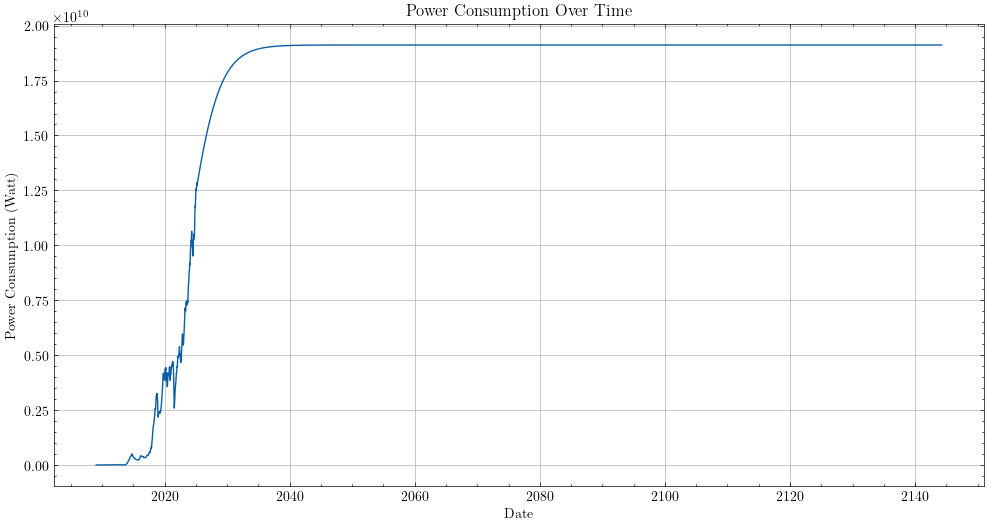

In [16]:
plt.figure(figsize=(12, 6))
plt.plot(forecast_df.index, forecast_df["Power Consumption (Watt)"])
plt.xlabel('Date')
plt.ylabel('Power Consumption (Watt)')
plt.title('Power Consumption Over Time')
plt.grid(True)
plt.show()

In [17]:
df

,Efficiency (J/TH),hash_rate,market_price,daily_transaction_fees,Power Consumption (Watt)
2009-01-25,4.844131e+06,5.681174e-06,0.000000,0.000000,2.794730e+01
2009-02-01,4.792175e+06,6.345161e-06,0.000000,0.000000,2.949981e+01
2009-02-08,4.740218e+06,6.043348e-06,0.000000,0.164082,2.947339e+01
2009-02-15,4.688262e+06,6.359364e-06,0.000000,0.164082,2.980391e+01
2009-02-22,4.636306e+06,6.178276e-06,0.000000,0.000000,3.025691e+01
...,...,...,...,...,...
2025-02-23,1.600000e+01,8.038637e+08,96675.969286,4.789333,1.283279e+10
2025-03-02,1.600000e+01,7.675328e+08,94877.577143,7.806708,1.279416e+10
2025-03-09,1.600000e+01,7.993316e+08,87776.206429,7.529198,1.270938e+10
2025-03-16,1.600000e+01,8.238128e+08,84799.241429,5.210903,1.277816e+10


In [18]:
last_known_value = df['daily_transaction_fees'].dropna().iloc[-1]

In [19]:
last_date = df.index[-1]
start_date = last_date + pd.Timedelta(days=1)
future_dates = pd.date_range(start=start_date,
                                periods=120*(365/7),
                                freq='W-SUN')

# Convert all times to numeric for forecasting
x_all = (future_dates - start_date).days.values.astype(float)
# Apply the fitted logistic function to the entire date range
y_all = logistic(x_all,last_known_value*20,0.0005,3000.,last_known_value)*np.random.uniform(0.1,1.0,len(x_all))
tran_fees = pd.concat([df[['daily_transaction_fees']],pd.DataFrame(pd.Series(data=y_all, index=future_dates), columns=['daily_transaction_fees'])])
tran_fees=tran_fees.resample('D').interpolate('linear').resample('W-SUN').mean()
tran_fees.plot()

C:\Users\pkapl\AppData\Local\Temp\ipykernel_16236\313098776.py:3: FutureWarning: Non-integer 'periods' in pd.date_range, pd.timedelta_range, pd.period_range, and pd.interval_range are deprecated and will raise in a future version.
  future_dates = pd.date_range(start=start_date,


<Axes: >

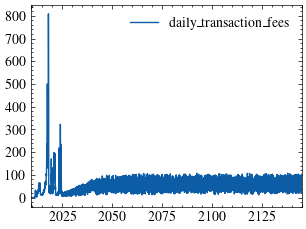

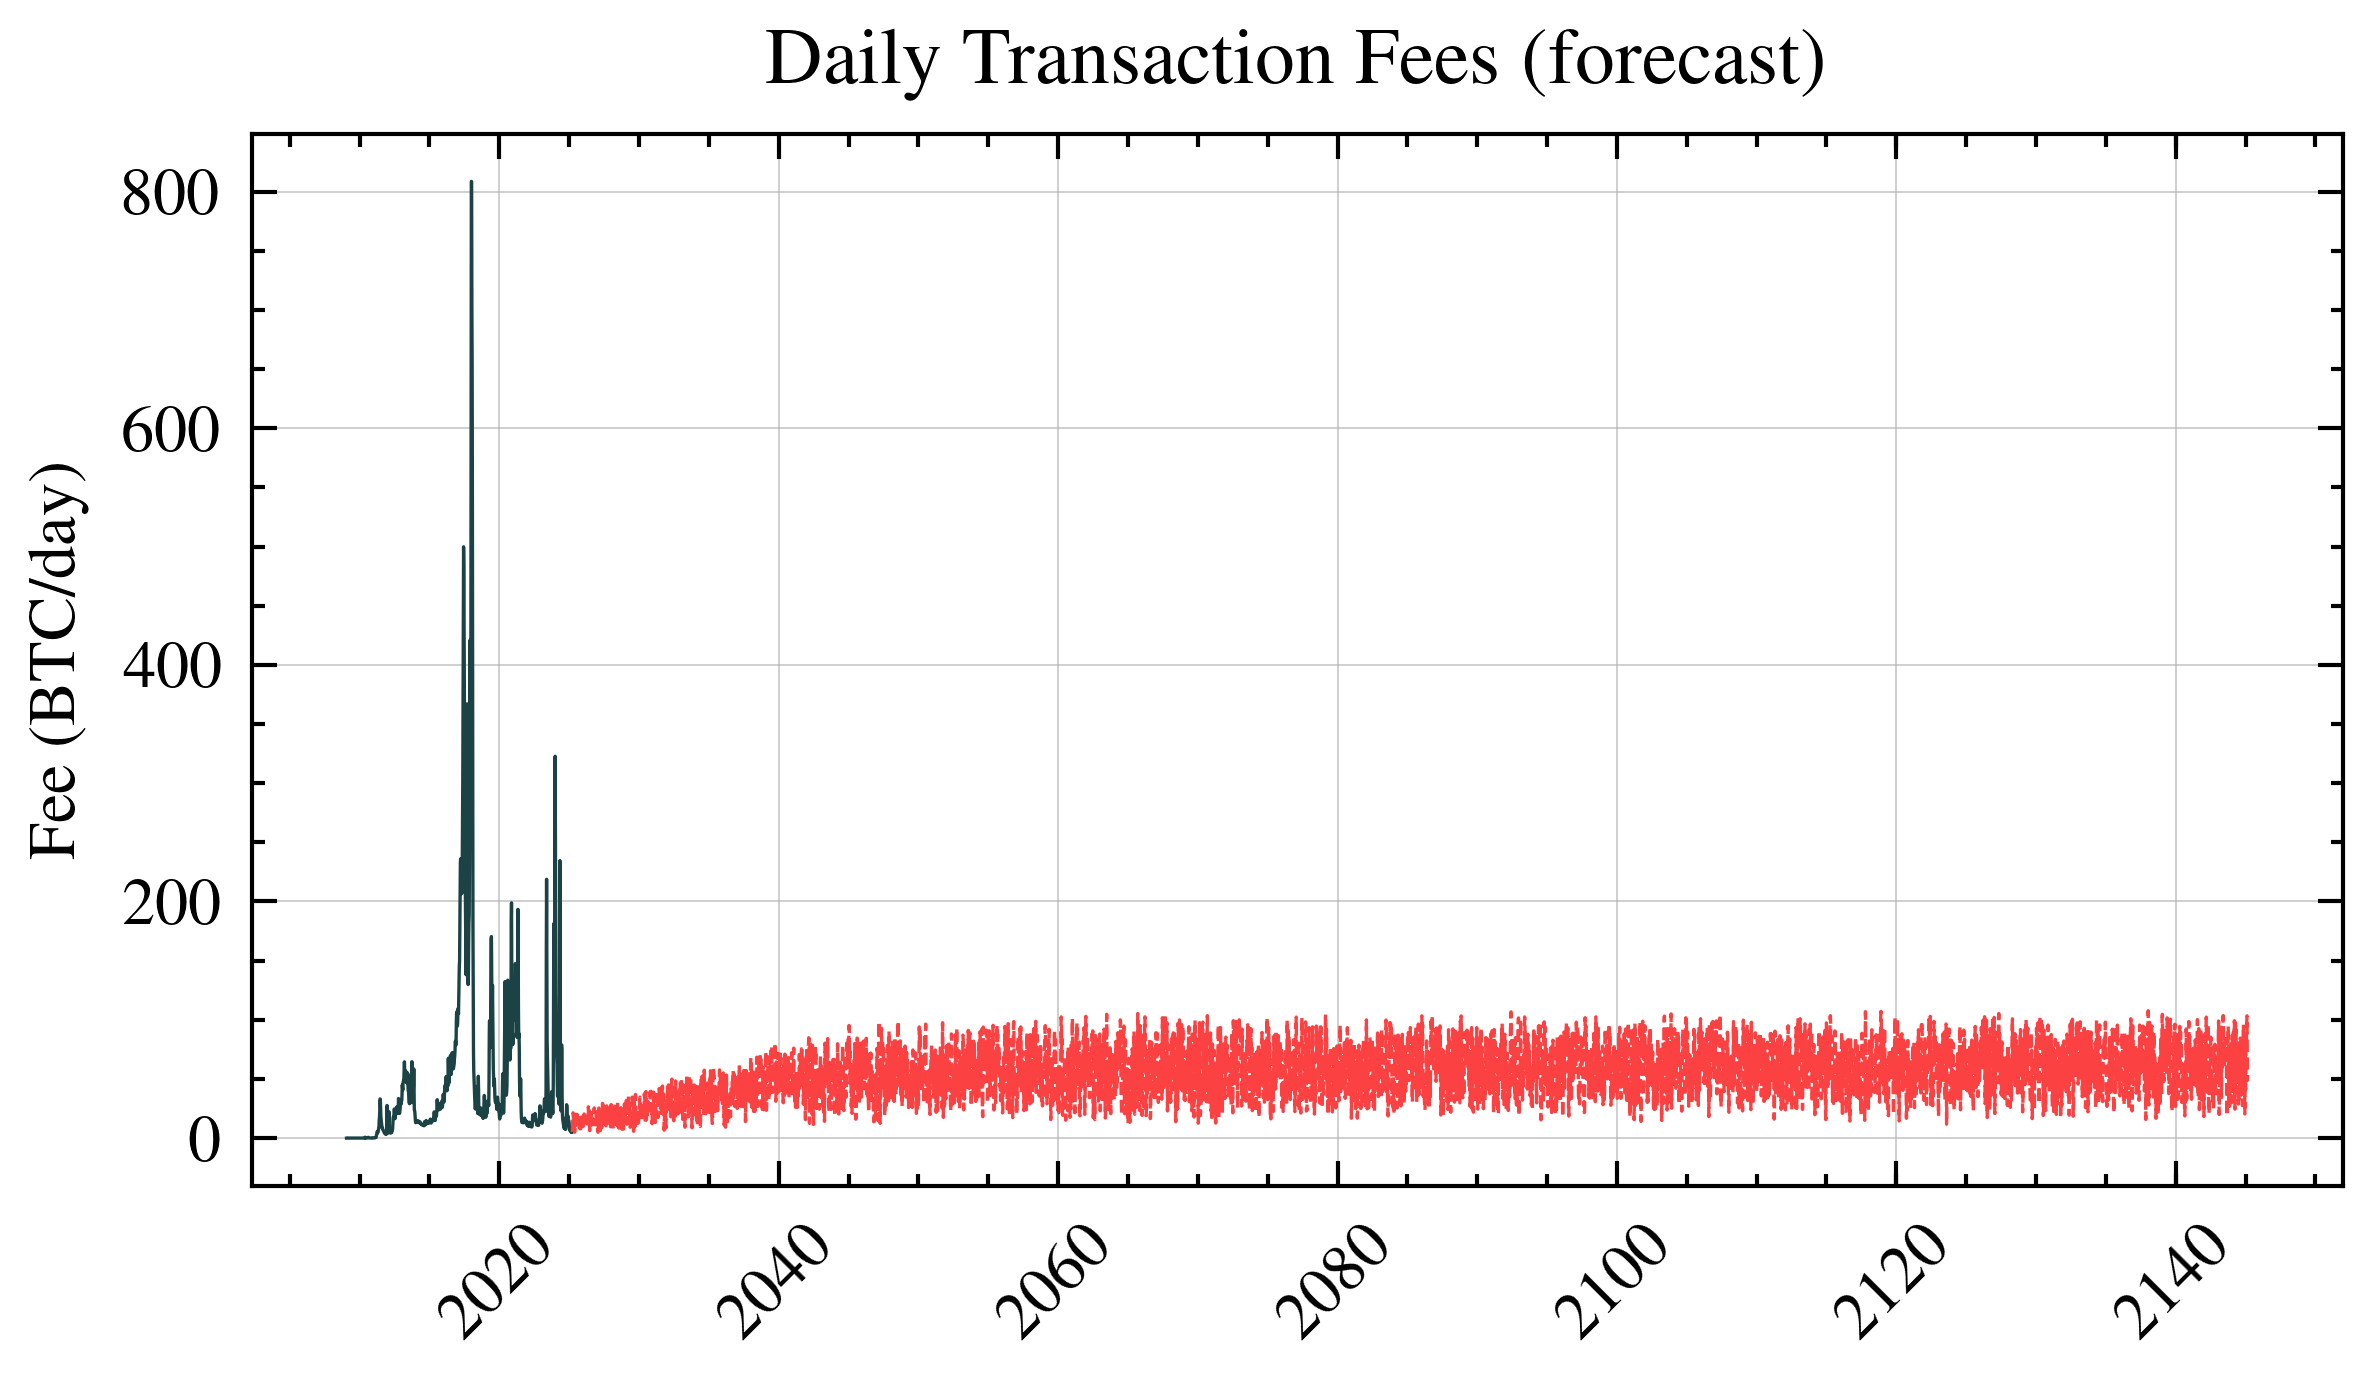

In [20]:
with plt.style.context(['science','ieee']):
    plt.figure(figsize=(4, 2.25))
    plt.grid(True, linestyle='-', alpha=0.7, linewidth=0.2)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.plot(tran_fees[:df.index[-1]].index, tran_fees[:df.index[-1]]['daily_transaction_fees'], linewidth=0.4, linestyle='-', color=LINE_COLOR)
    plt.plot(tran_fees[df.index[-1]:].index, tran_fees[df.index[-1]:]['daily_transaction_fees'], linewidth=0.4, linestyle='--', color=LINE_COLOR_RED)
    plt.ylabel('Fee (BTC/day)')
    plt.title('Daily Transaction Fees (forecast)')
    plt.savefig(ASSETS+'transactionfeesforecast1.png')
    plt.show()
    

In [21]:
main_df=forecast_df.join(tran_fees,how="outer").join(electricity_price).join(total_bitcoins).join(simulated_bitcoins.rename(columns={"total_bitcoins":"simulated_total_bitcoins"}),how="outer")
main_df['delta_total_bitcoins'] = main_df['total_bitcoins'].diff().rolling(4).mean()+(main_df['daily_transaction_fees']*7)
main_df['mining_cost'] = ((main_df["Power Consumption (Watt)"]  / 1000 * 24 * 7 * main_df['COM']/100) / main_df['delta_total_bitcoins']).rolling(window=12).mean()
main_df=main_df.join(onchain[['market_price']])

In [22]:
main_df["delta_simulated_total_bitcoins_annual"]=(main_df['simulated_total_bitcoins'].diff())*365/7
main_df["stock_to_flow"]=np.exp(-1.84)*(main_df["simulated_total_bitcoins"]/main_df["delta_simulated_total_bitcoins_annual"])**3.36
#main_df["stock_to_flow"]=0.25*(main_df["simulated_total_bitcoins"]/main_df["delta_simulated_total_bitcoins_annual"])**3

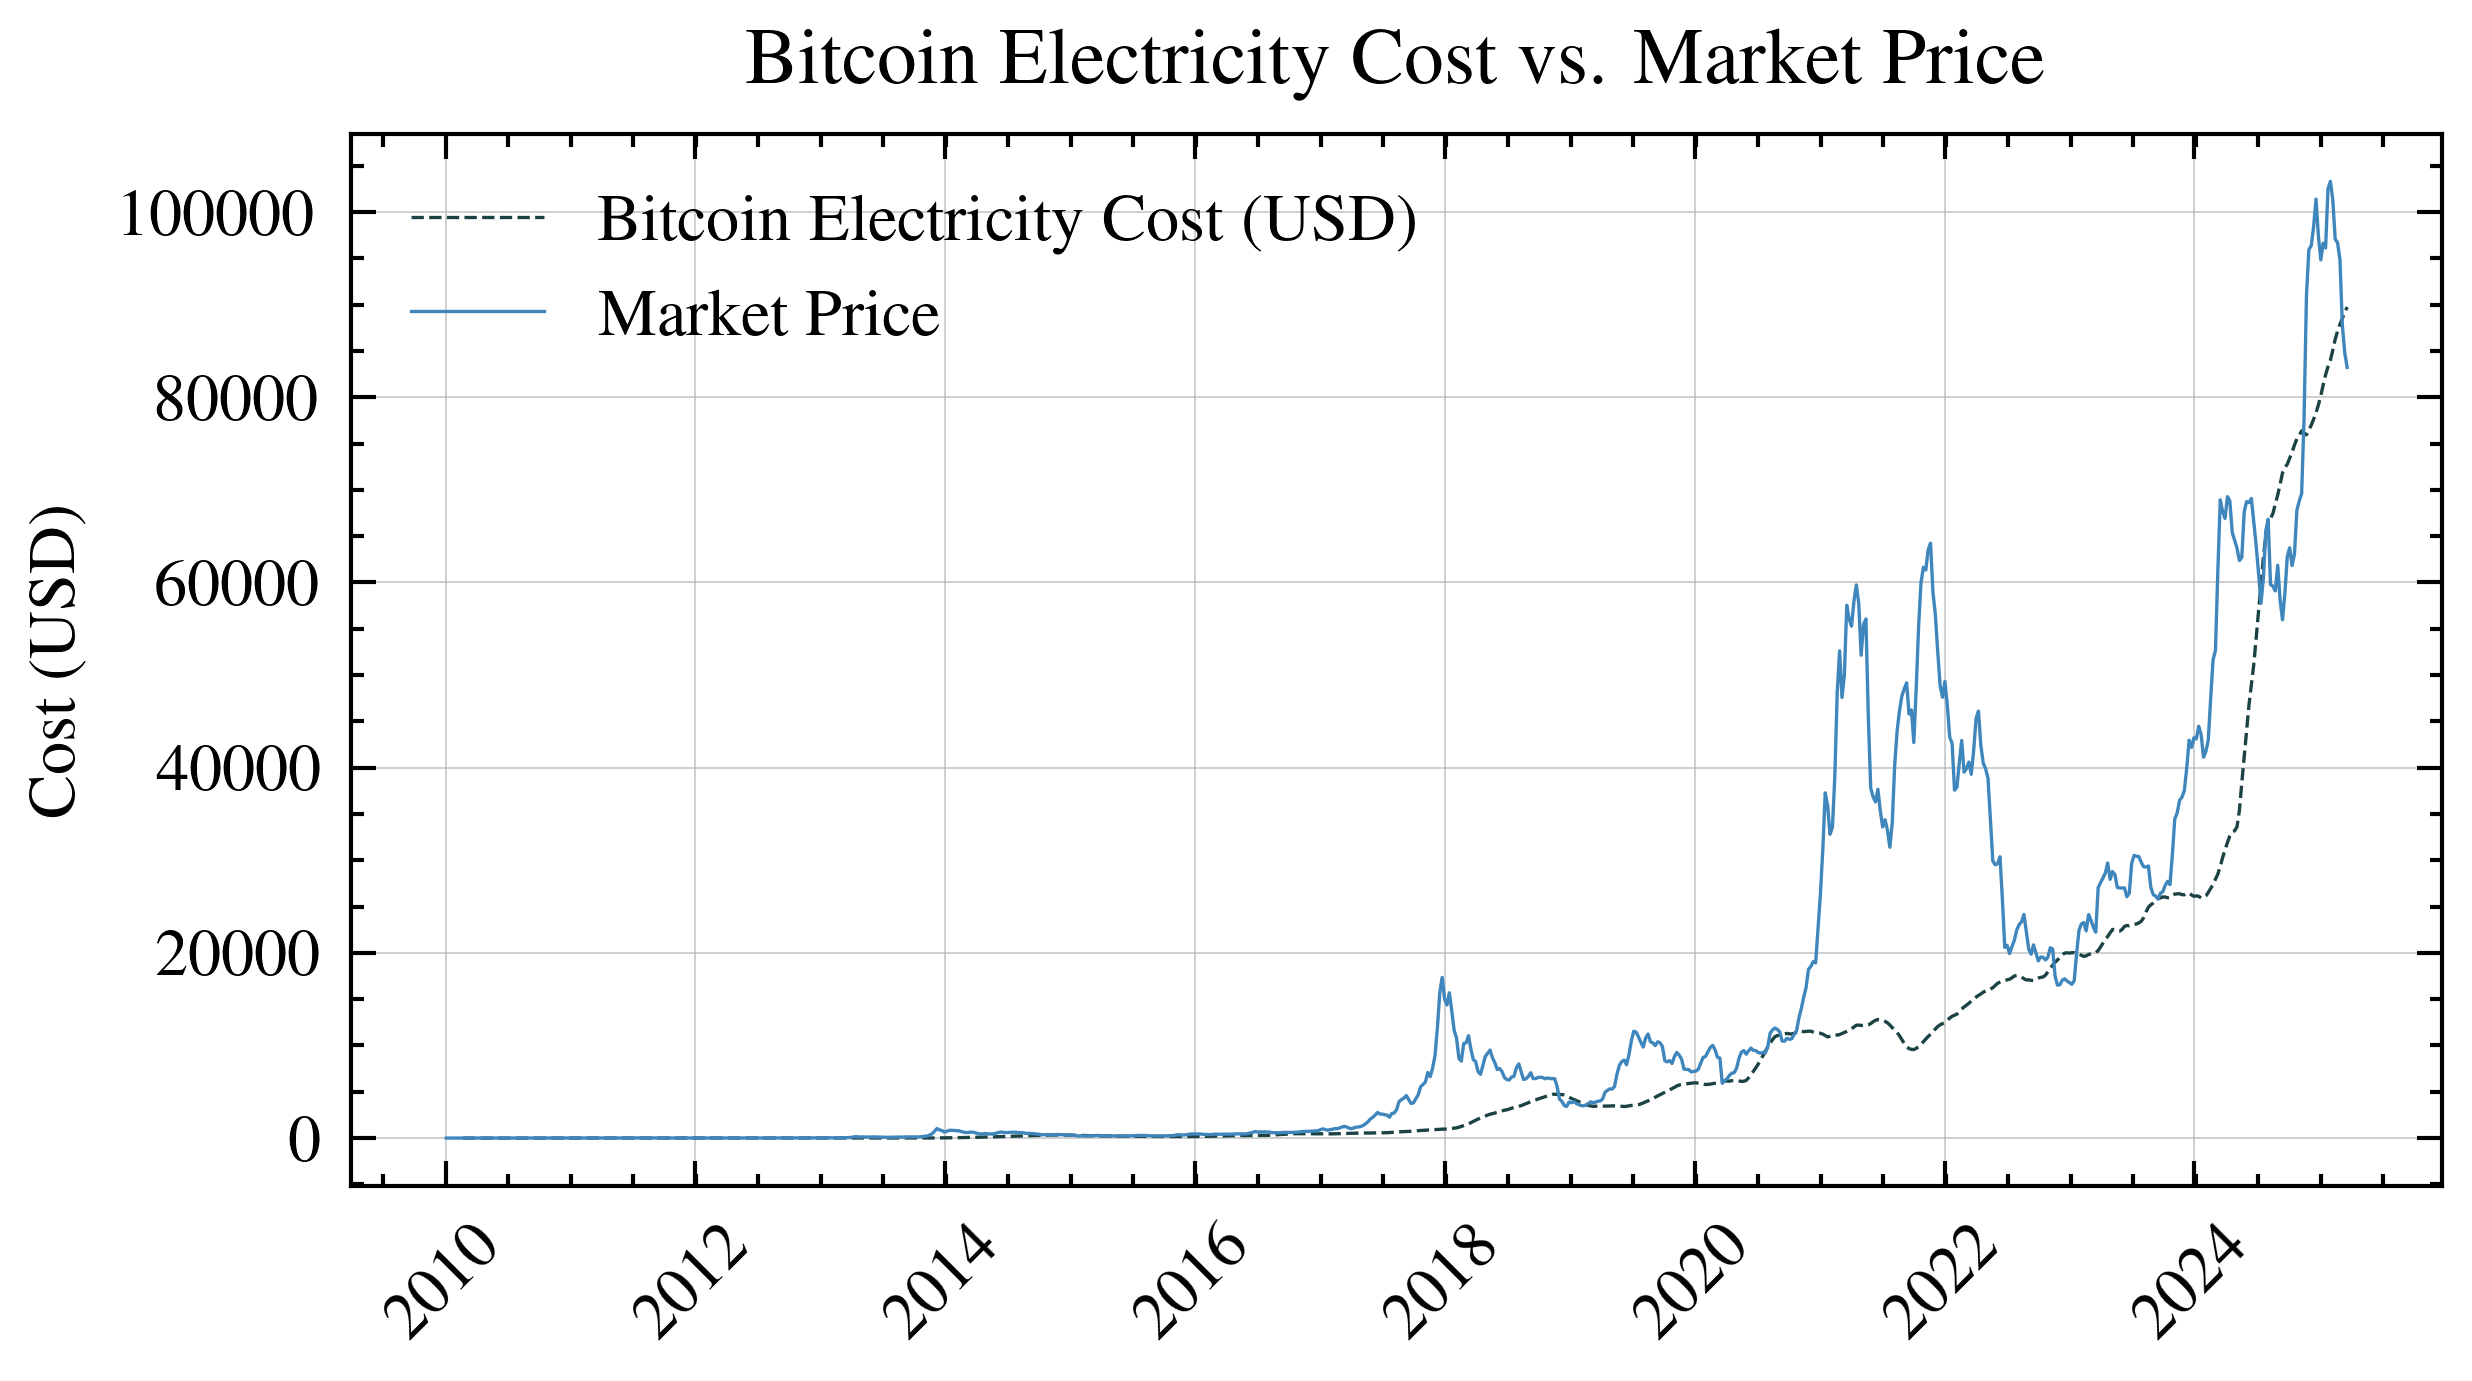

In [23]:
df_filtered = main_df['2010-01-01':df.index[-1]].copy()
with plt.style.context(['science','ieee']):
    plt.figure(figsize=(4, 2.25))
    plt.grid(True, linestyle='-', alpha=0.7, linewidth=0.2)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.plot(df_filtered.index, df_filtered['mining_cost'], label='Bitcoin Electricity Cost (USD)', color=LINE_COLOR, linestyle='--', linewidth=0.4)
    plt.plot(df_filtered.index, df_filtered['market_price'], label='Market Price',color=LINE_COLOR_BLUE,  linestyle='-', linewidth=0.4)
#    plt.plot(df_filtered.index, df_filtered['stock_to_flow'], label='Stock To Flow',color=LINE_COLOR_GREEN,  linestyle='-', linewidth=0.4)
    plt.ylabel('Cost (USD)')
    plt.title('Bitcoin Electricity Cost vs. Market Price')
    plt.legend()
    plt.savefig(ASSETS+'miningcost1.png')
    plt.show()

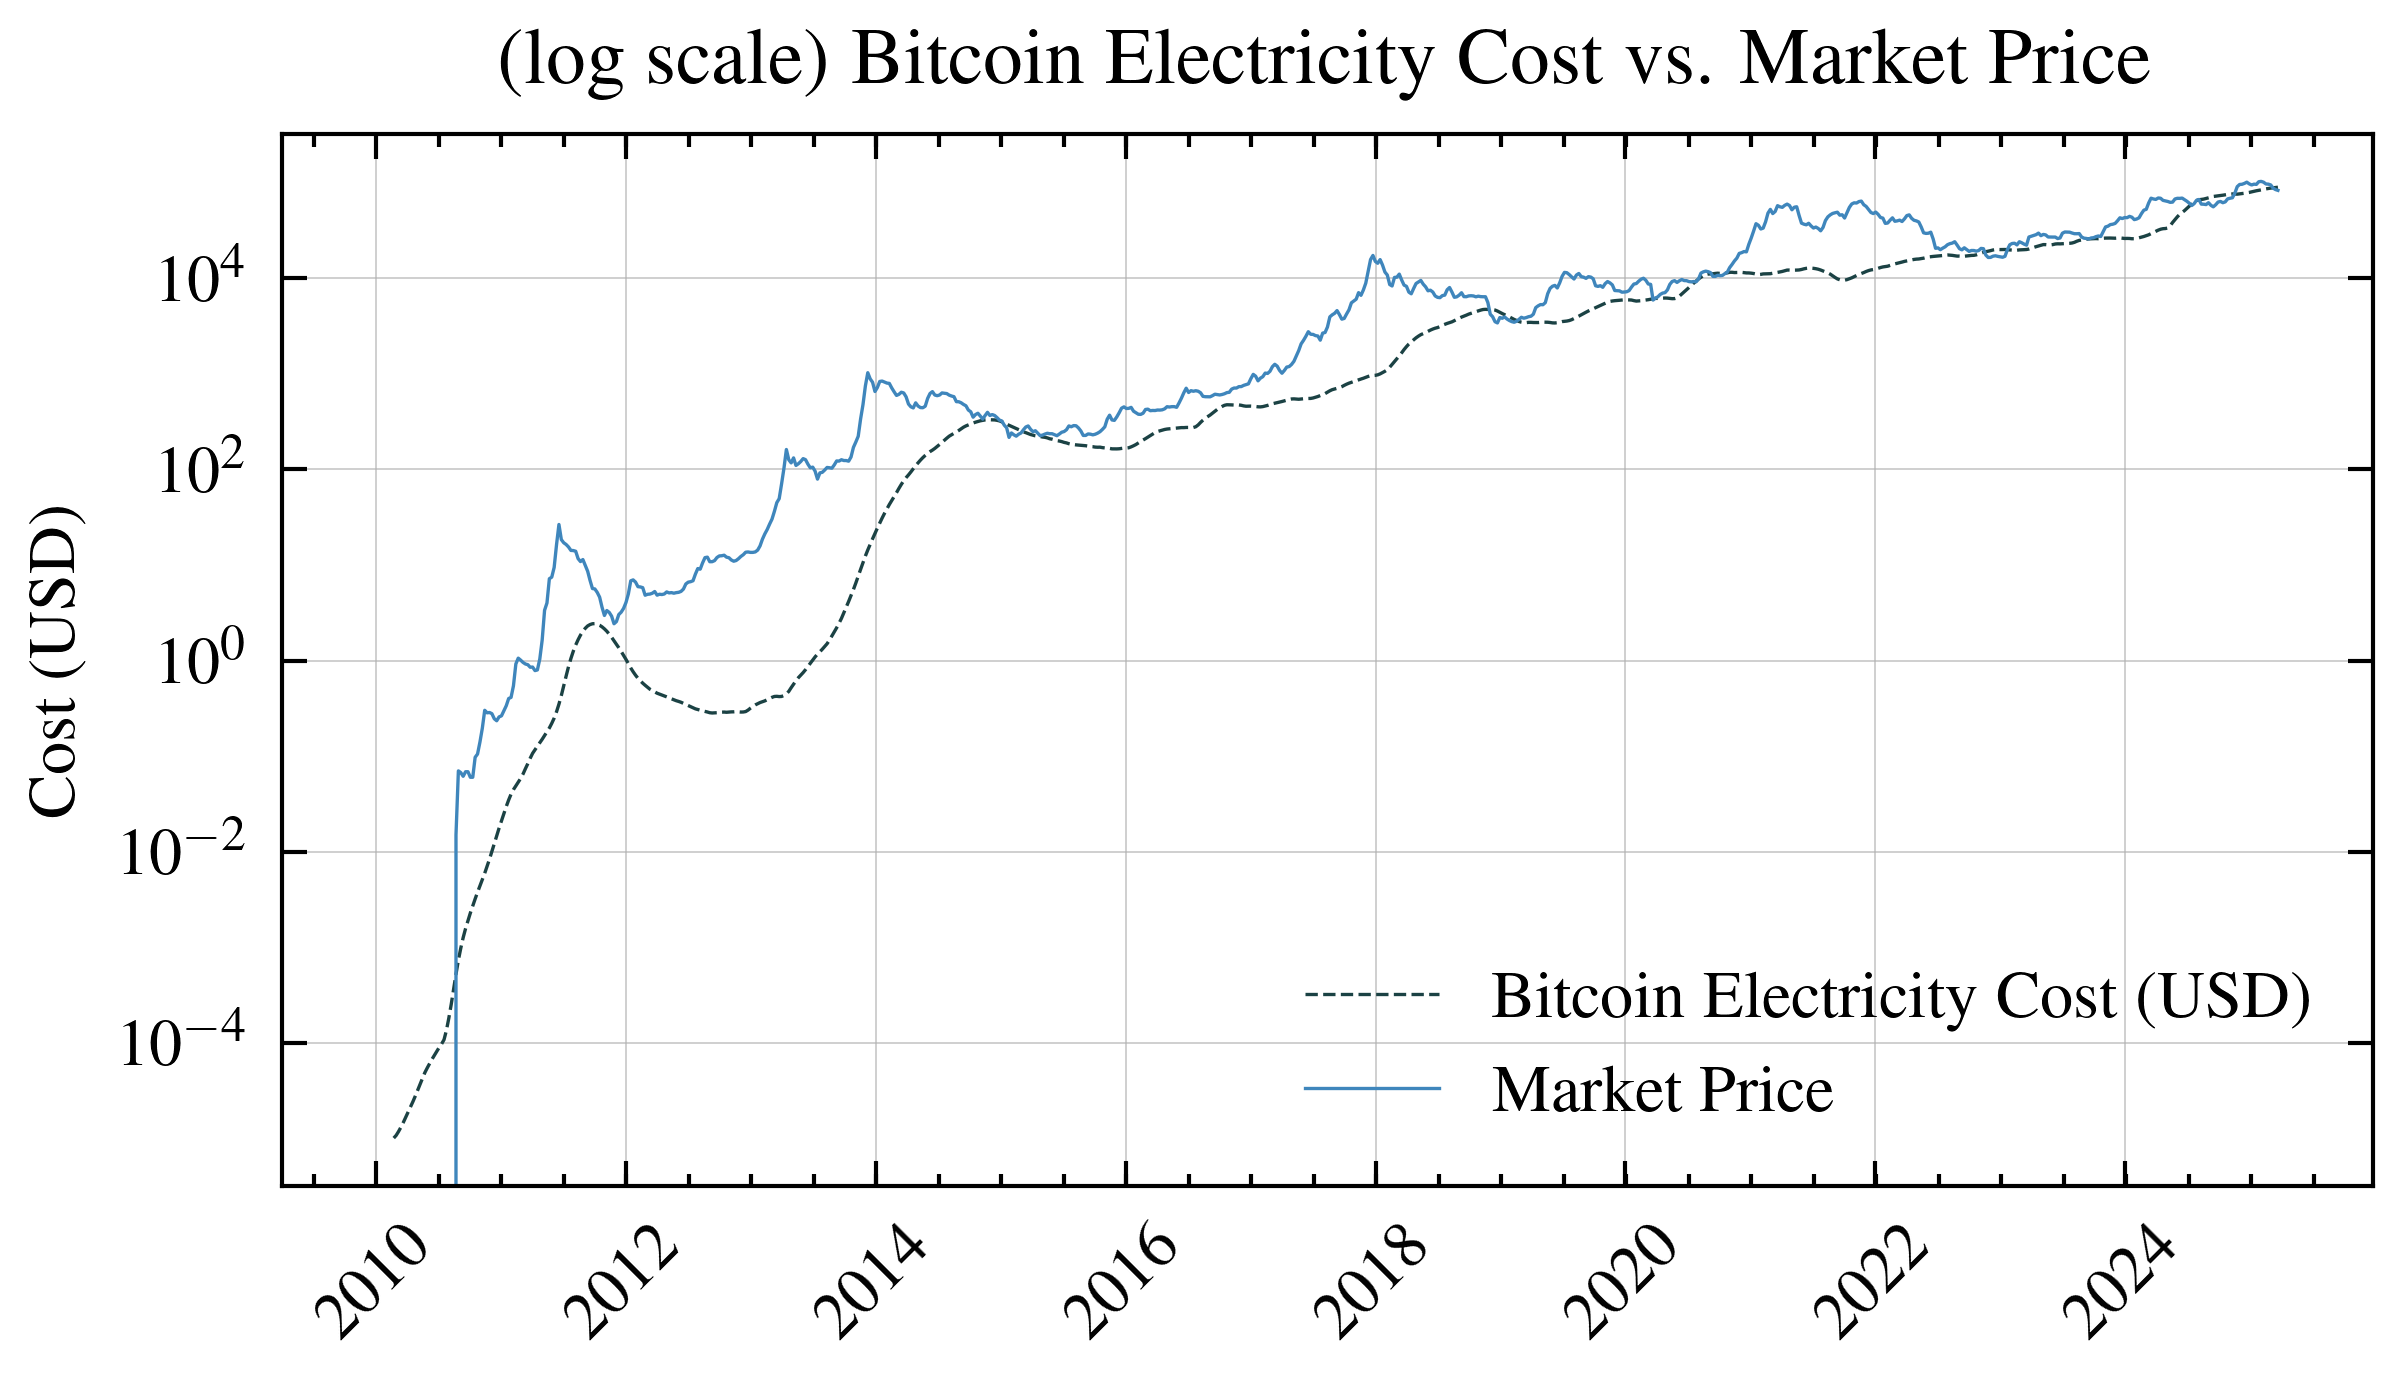

In [24]:
df_filtered = main_df['2010-01-01':df.index[-1]].copy()
with plt.style.context(['science','ieee']):
    plt.figure(figsize=(4, 2.25))
    plt.grid(True, linestyle='-', alpha=0.7, linewidth=0.2)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.plot(df_filtered.index, df_filtered['mining_cost'], label='Bitcoin Electricity Cost (USD)', color=LINE_COLOR, linestyle='--', linewidth=0.4)
    plt.plot(df_filtered.index, df_filtered['market_price'], label='Market Price',color=LINE_COLOR_BLUE,  linestyle='-', linewidth=0.4)
#    plt.plot(df_filtered.index, df_filtered['stock_to_flow'], label='Stock To Flow',color=LINE_COLOR_GREEN,  linestyle='-', linewidth=0.4)
    plt.ylabel('Cost (USD)')
    plt.title('(log scale) Bitcoin Electricity Cost vs. Market Price')
    plt.legend()
    plt.yscale('log')
    plt.savefig(ASSETS+'miningcost2.png')
    plt.show()

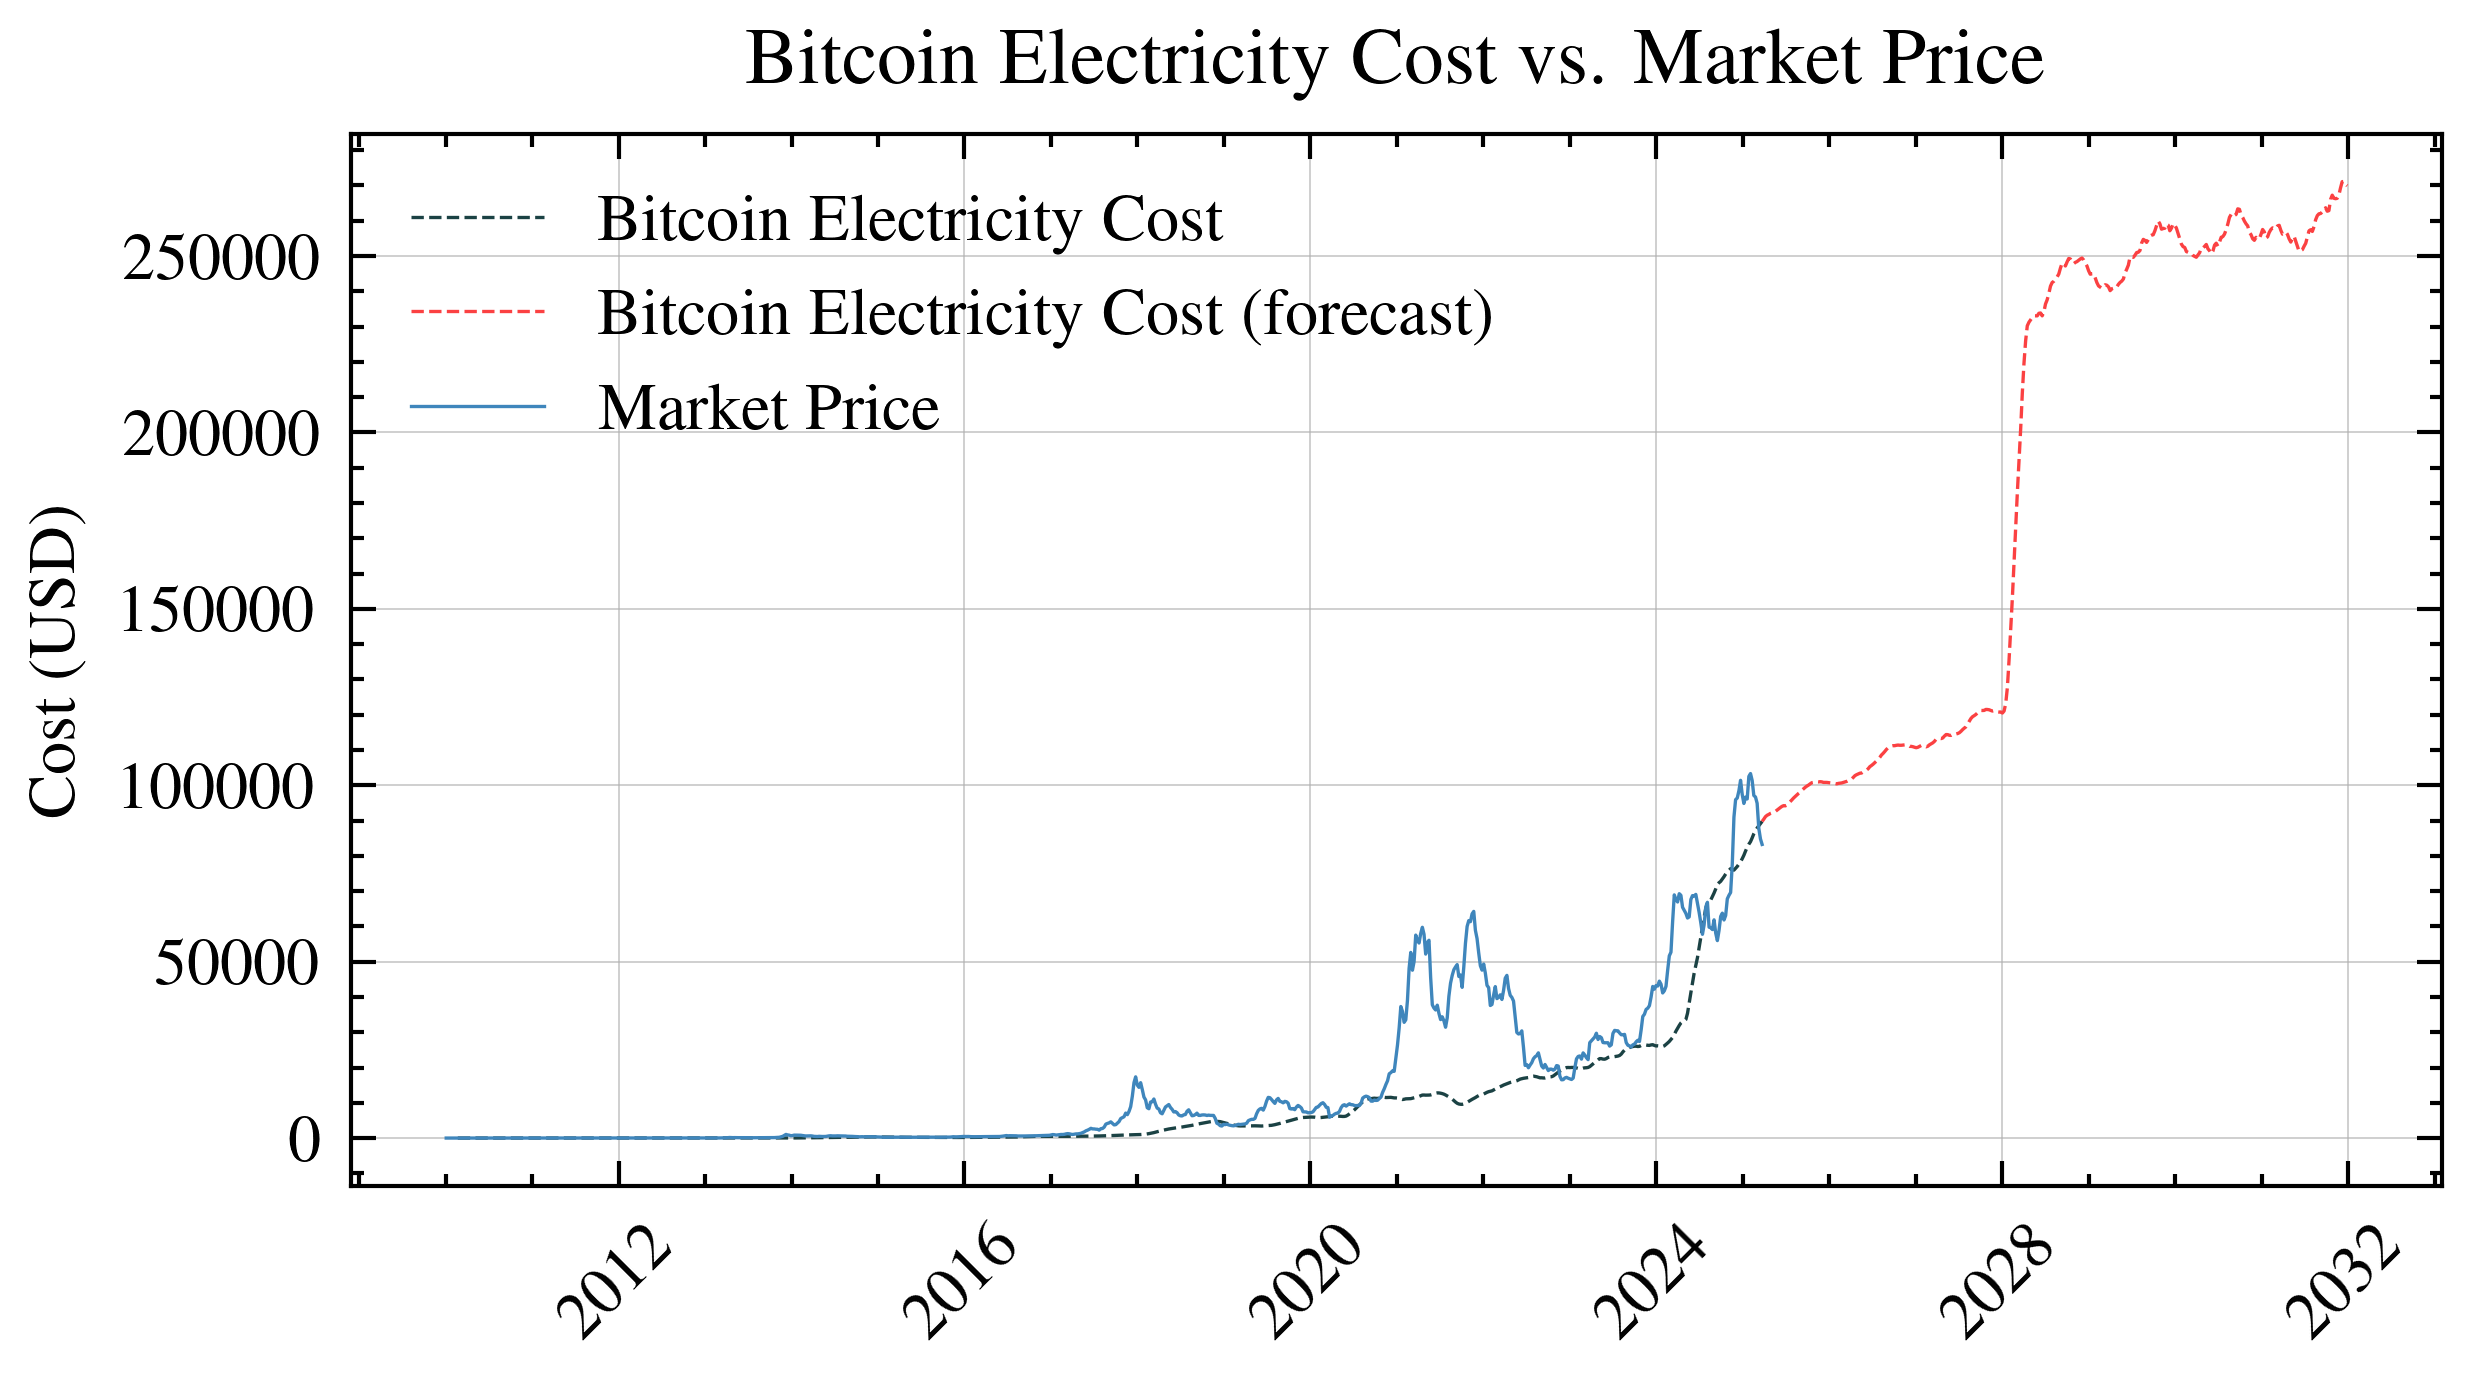

In [25]:
df_filtered = main_df['2010-01-01':'2032-01-01'].copy()
with plt.style.context(['science','ieee']):
    plt.figure(figsize=(4, 2.25))
    plt.grid(True, linestyle='-', alpha=0.7, linewidth=0.2)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.plot(df_filtered[:df.index[-1]].index, df_filtered[:df.index[-1]]['mining_cost'], label='Bitcoin Electricity Cost', color=LINE_COLOR, linestyle='--', linewidth=0.4)
    plt.plot(df_filtered[df.index[-1]:].index, df_filtered[df.index[-1]:]['mining_cost'], label='Bitcoin Electricity Cost (forecast)', color=LINE_COLOR_RED, linestyle='--', linewidth=0.4)
    plt.plot(df_filtered.index, df_filtered['market_price'], label='Market Price',color=LINE_COLOR_BLUE,  linestyle='-', linewidth=0.4)
#    plt.plot(df_filtered.index, df_filtered['stock_to_flow'], label='Stock To Flow',color=LINE_COLOR_GREEN,  linestyle='-', linewidth=0.4)
    plt.ylabel('Cost (USD)')
    plt.title('Bitcoin Electricity Cost vs. Market Price')
    plt.legend()
    plt.savefig(ASSETS+'miningcostforecast1.png')
    plt.show()

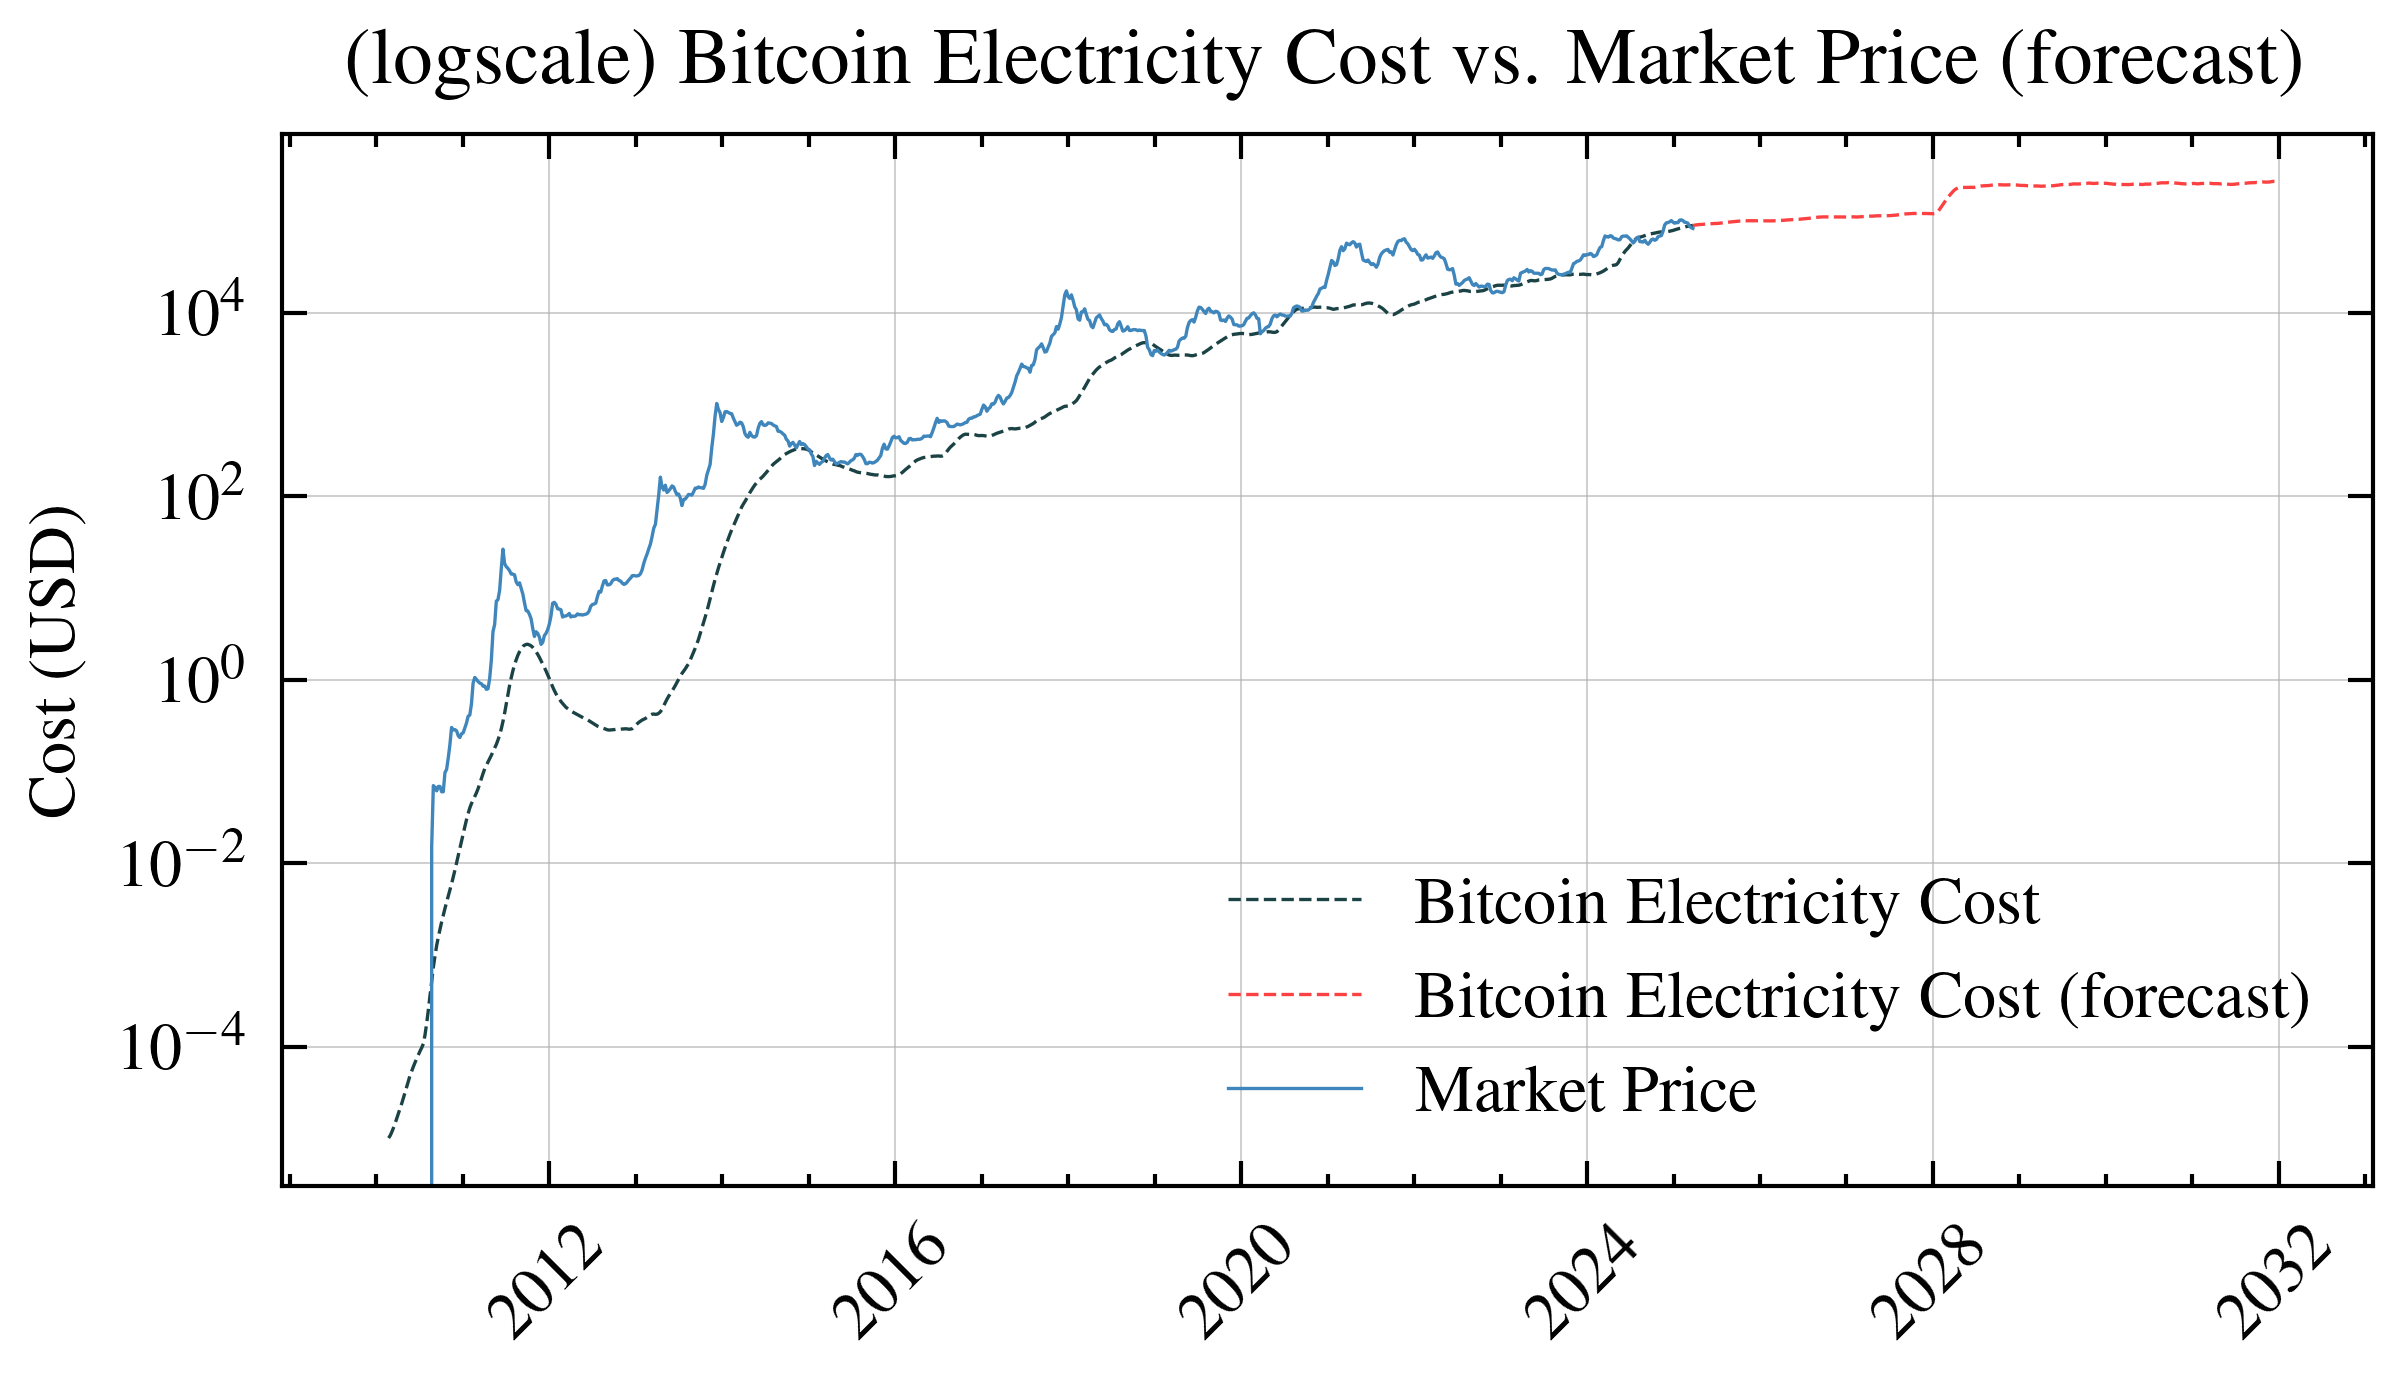

In [26]:
df_filtered = main_df['2010-01-01':'2032-01-01'].copy()
with plt.style.context(['science','ieee']):
    plt.figure(figsize=(4, 2.25))
    plt.grid(True, linestyle='-', alpha=0.7, linewidth=0.2)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.plot(df_filtered[:df.index[-1]].index, df_filtered[:df.index[-1]]['mining_cost'], label='Bitcoin Electricity Cost', color=LINE_COLOR, linestyle='--', linewidth=0.4)
    plt.plot(df_filtered[df.index[-1]:].index, df_filtered[df.index[-1]:]['mining_cost'], label='Bitcoin Electricity Cost (forecast)', color=LINE_COLOR_RED, linestyle='--', linewidth=0.4)
    plt.plot(df_filtered.index, df_filtered['market_price'], label='Market Price',color=LINE_COLOR_BLUE,  linestyle='-', linewidth=0.4)
#    plt.plot(df_filtered.index, df_filtered['stock_to_flow'], label='Stock To Flow',color=LINE_COLOR_GREEN,  linestyle='-', linewidth=0.4)
    plt.ylabel('Cost (USD)')
    plt.title('(logscale) Bitcoin Electricity Cost vs. Market Price (forecast)')
    plt.legend()
    plt.yscale('log')
    plt.savefig(ASSETS+'miningcostforecast2.png')
    plt.show()

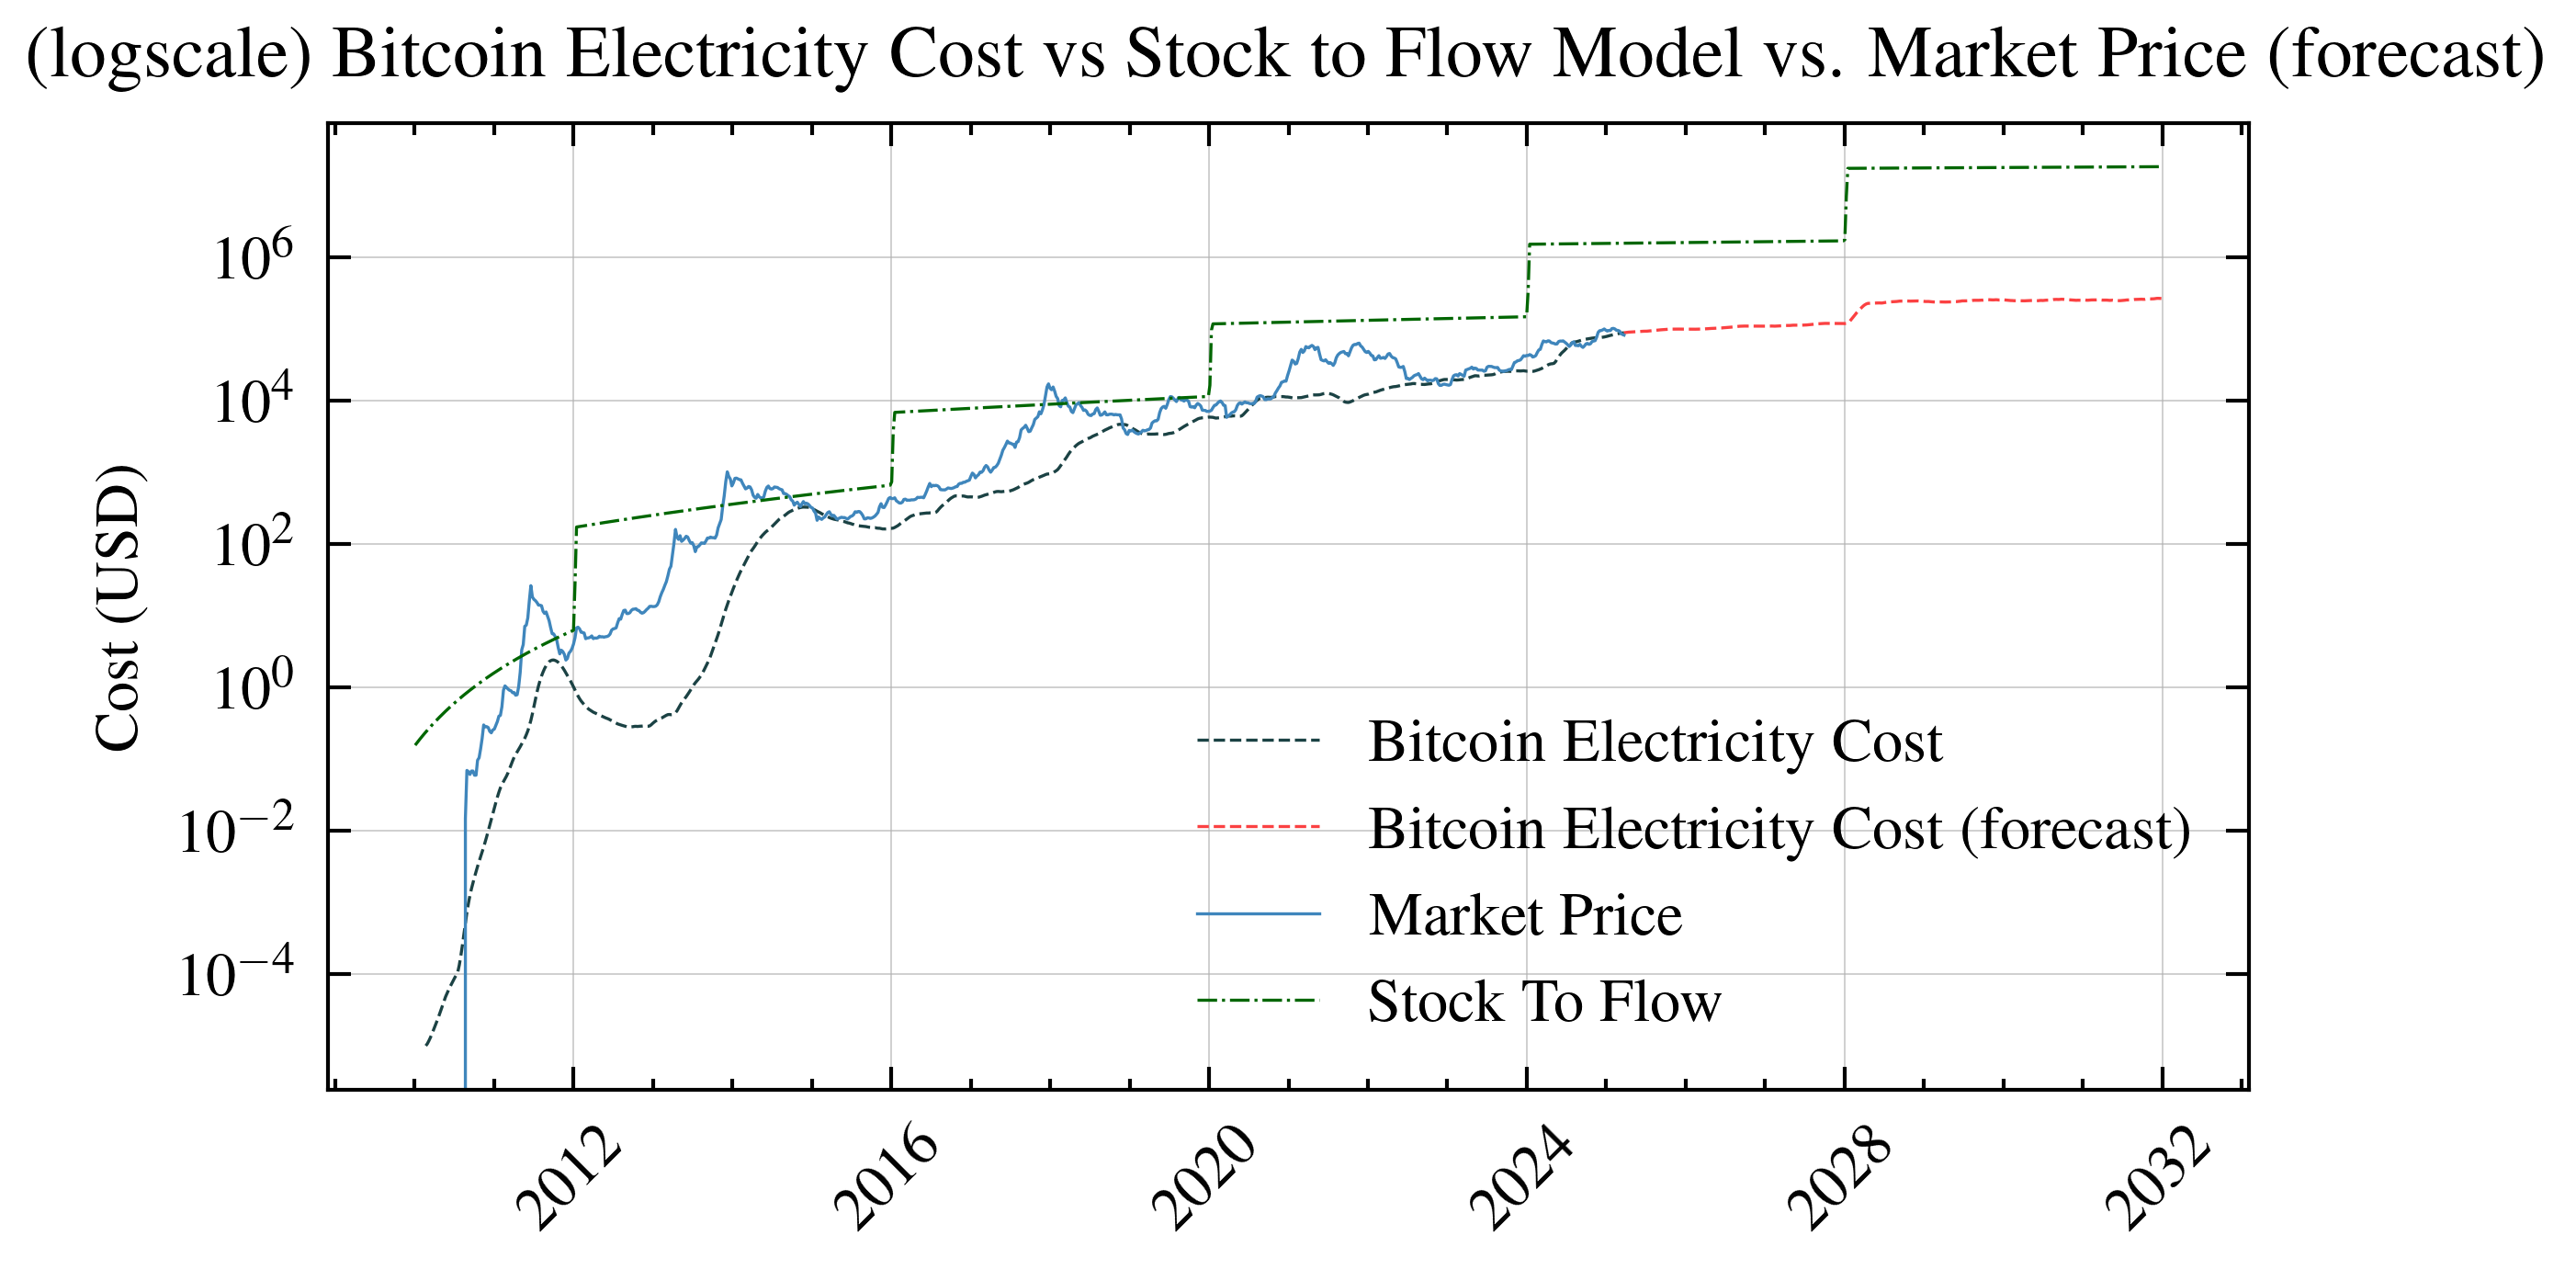

In [27]:
df_filtered = main_df['2010-01-01':'2032-01-01'].copy()
with plt.style.context(['science','ieee']):
    plt.figure(figsize=(4, 2.25))
    plt.grid(True, linestyle='-', alpha=0.7, linewidth=0.2)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.plot(df_filtered[:df.index[-1]].index, df_filtered[:df.index[-1]]['mining_cost'], label='Bitcoin Electricity Cost', color=LINE_COLOR, linestyle='--', linewidth=0.4)
    plt.plot(df_filtered[df.index[-1]:].index, df_filtered[df.index[-1]:]['mining_cost'], label='Bitcoin Electricity Cost (forecast)', color=LINE_COLOR_RED, linestyle='--', linewidth=0.4)
    plt.plot(df_filtered.index, df_filtered['market_price'], label='Market Price',color=LINE_COLOR_BLUE,  linestyle='-', linewidth=0.4)
    plt.plot(df_filtered.index, df_filtered['stock_to_flow'], label='Stock To Flow',color=LINE_COLOR_GREEN,  linestyle='-.', linewidth=0.4)
    plt.ylabel('Cost (USD)')
    plt.title('(logscale) Bitcoin Electricity Cost vs Stock to Flow Model vs. Market Price (forecast)')
    plt.legend()
    plt.yscale('log')
    plt.savefig(ASSETS+'miningcostforecaststf1.png')
    plt.show()

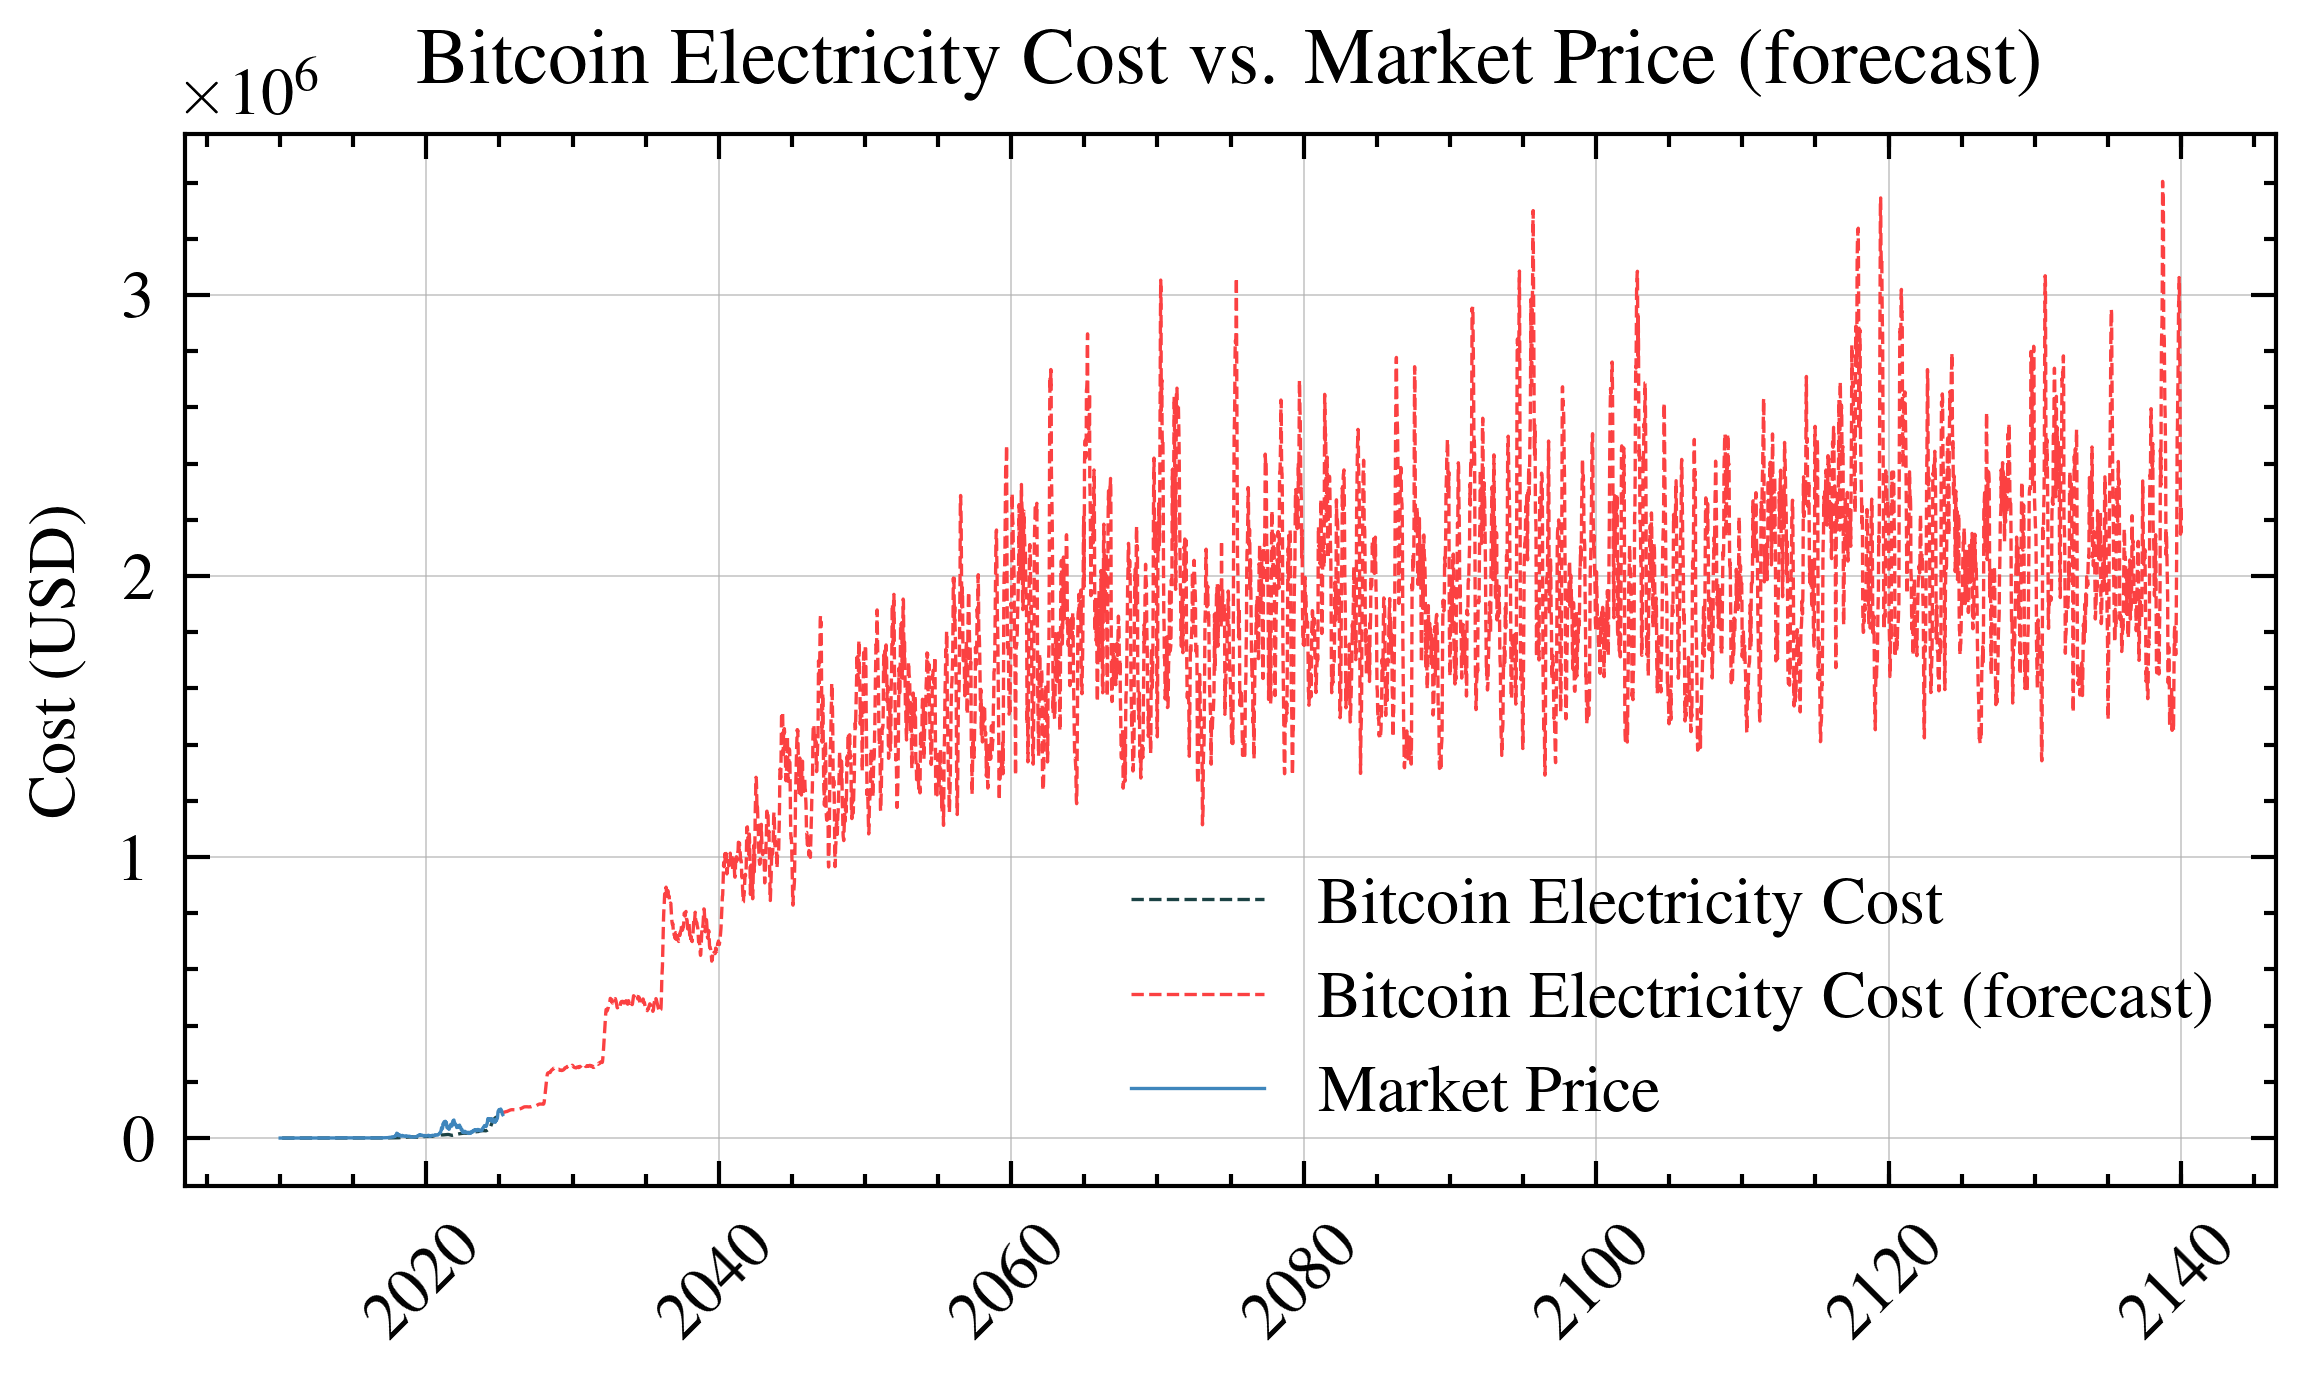

In [28]:
df_filtered = main_df['2010-01-01':'2232-01-01'].copy()
with plt.style.context(['science','ieee']):
    plt.figure(figsize=(4, 2.25))
    plt.grid(True, linestyle='-', alpha=0.7, linewidth=0.2)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.plot(df_filtered[:df.index[-1]].index, df_filtered[:df.index[-1]]['mining_cost'], label='Bitcoin Electricity Cost', color=LINE_COLOR, linestyle='--', linewidth=0.4)
    plt.plot(df_filtered[df.index[-1]:].index, df_filtered[df.index[-1]:]['mining_cost'], label='Bitcoin Electricity Cost (forecast)', color=LINE_COLOR_RED, linestyle='--', linewidth=0.4)
    plt.plot(df_filtered.index, df_filtered['market_price'], label='Market Price',color=LINE_COLOR_BLUE,  linestyle='-', linewidth=0.4)
 #   plt.plot(df_filtered.index, df_filtered['stock_to_flow'], label='Stock To Flow',color=LINE_COLOR_GREEN,  linestyle='-', linewidth=0.4)
    plt.ylabel('Cost (USD)')
    plt.title('Bitcoin Electricity Cost vs. Market Price (forecast)')
    plt.legend()
    plt.savefig(ASSETS+'miningcostforecast3.png')
    plt.show()

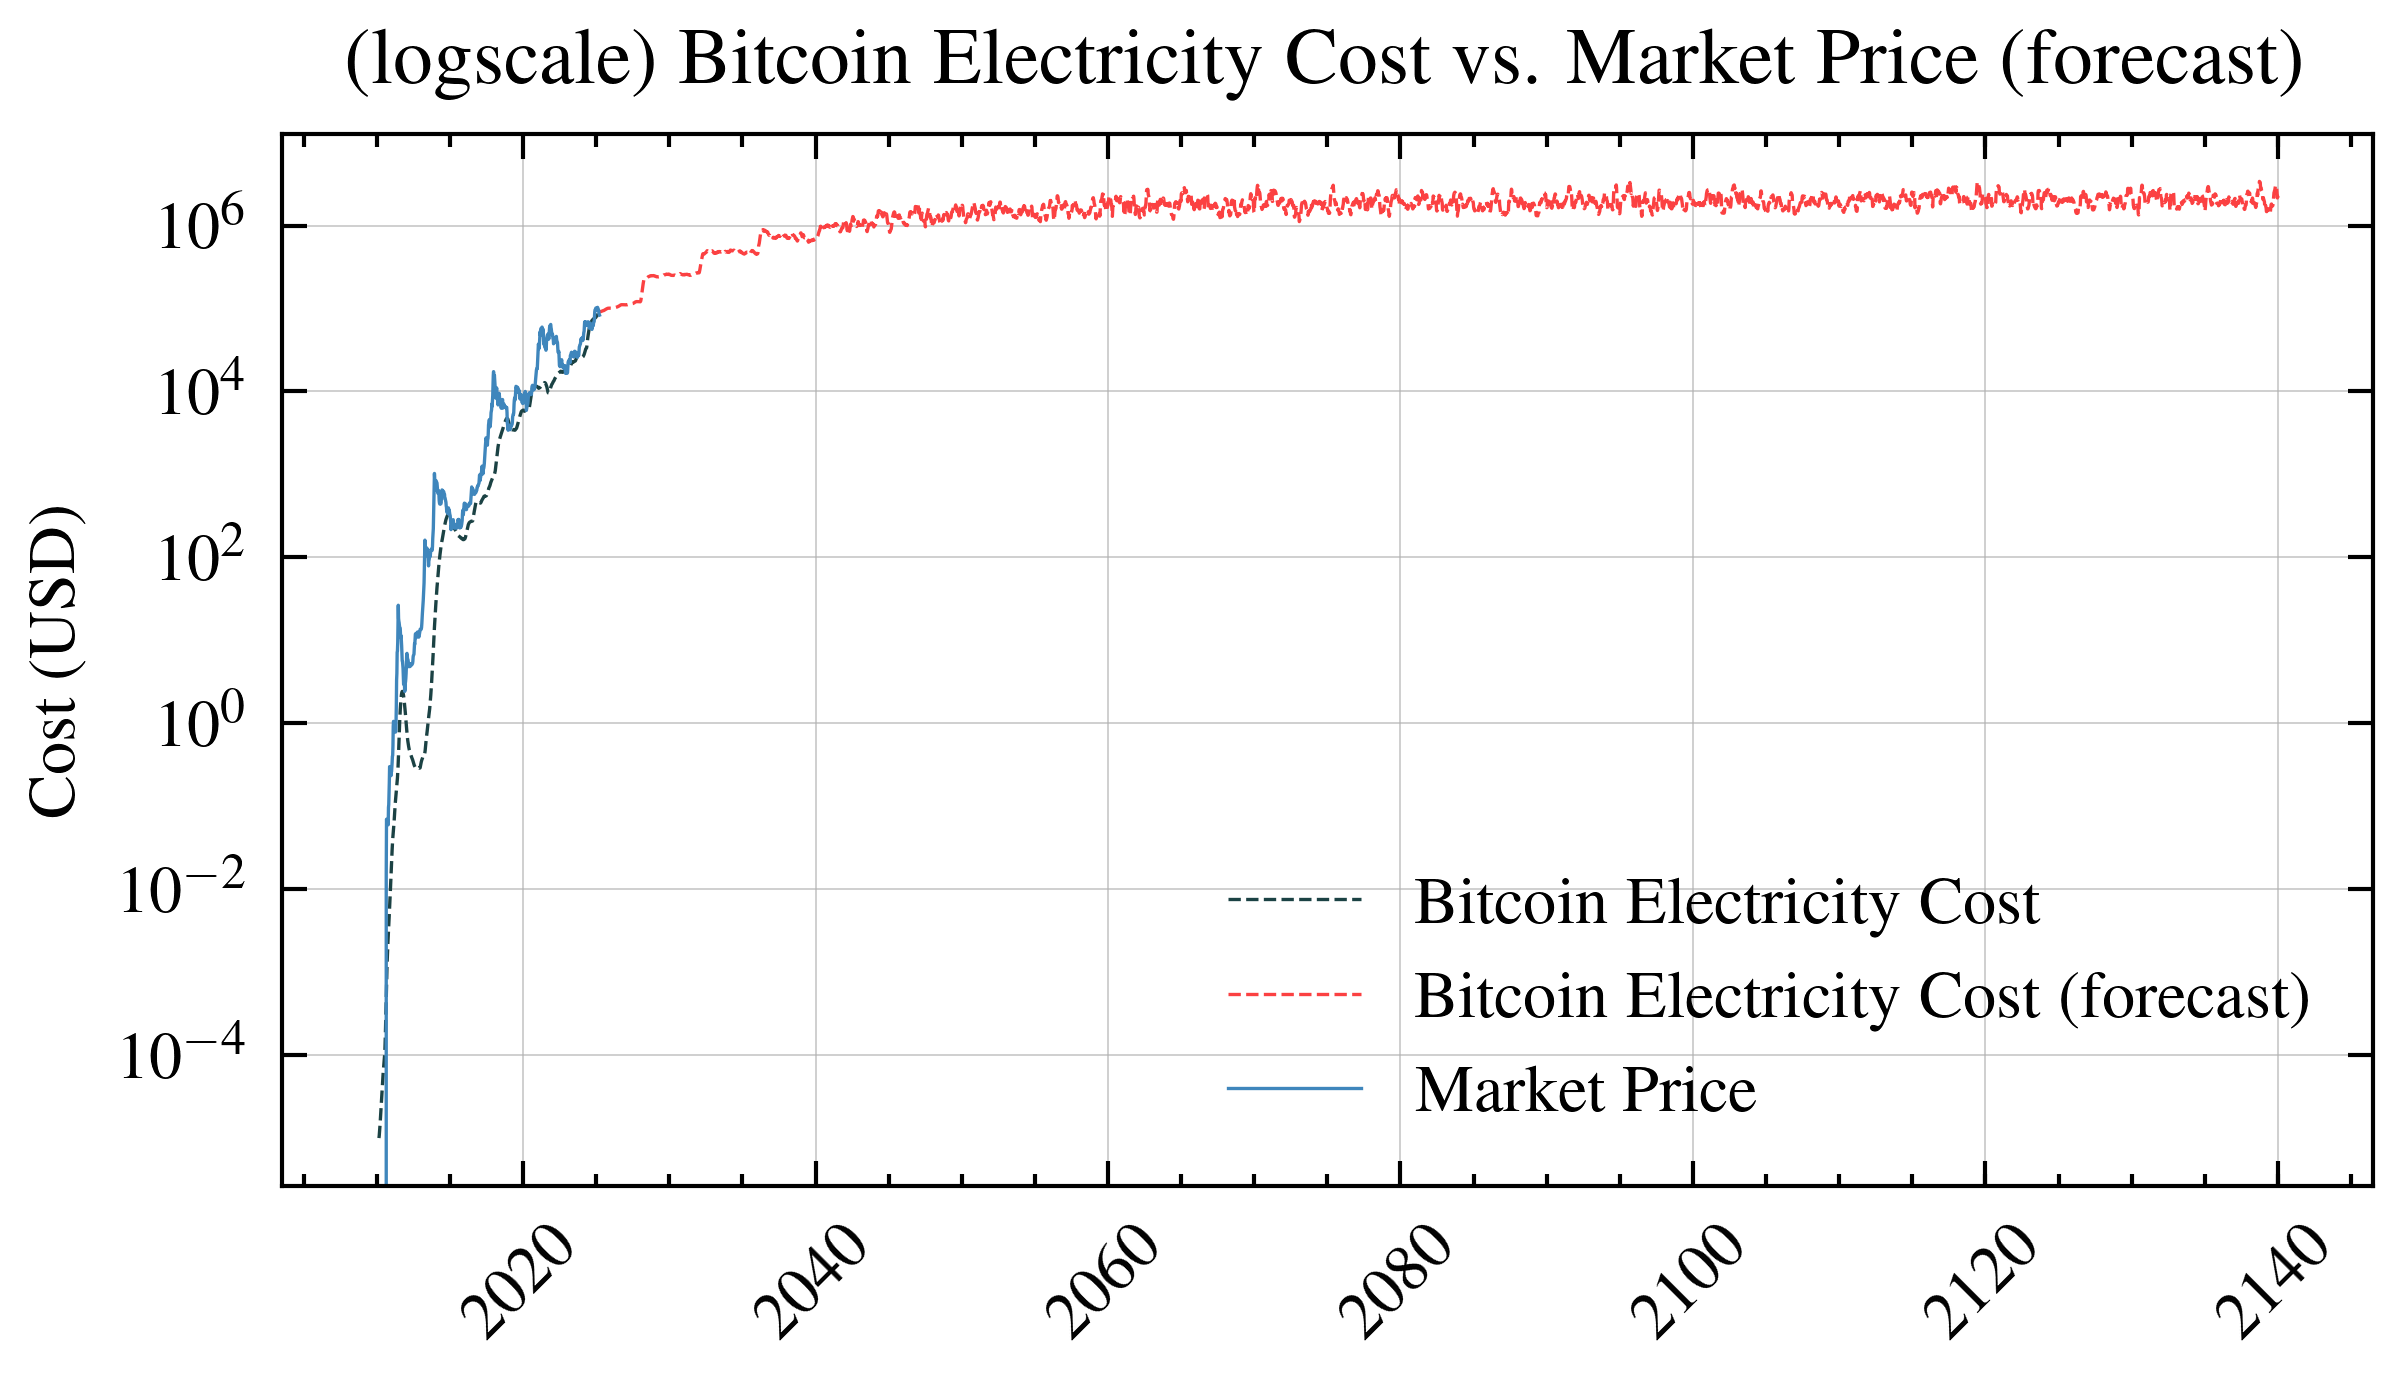

In [29]:
df_filtered = main_df['2010-01-01':'2232-01-01'].copy()
with plt.style.context(['science','ieee']):
    plt.figure(figsize=(4, 2.25))
    plt.grid(True, linestyle='-', alpha=0.7, linewidth=0.2)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.plot(df_filtered[:df.index[-1]].index, df_filtered[:df.index[-1]]['mining_cost'], label='Bitcoin Electricity Cost', color=LINE_COLOR, linestyle='--', linewidth=0.4)
    plt.plot(df_filtered[df.index[-1]:].index, df_filtered[df.index[-1]:]['mining_cost'], label='Bitcoin Electricity Cost (forecast)', color=LINE_COLOR_RED, linestyle='--', linewidth=0.4)
    plt.plot(df_filtered.index, df_filtered['market_price'], label='Market Price',color=LINE_COLOR_BLUE,  linestyle='-', linewidth=0.4)
#    plt.plot(df_filtered.index, df_filtered['stock_to_flow'], label='Stock To Flow',color=LINE_COLOR_GREEN,  linestyle='-', linewidth=0.4)
    plt.ylabel('Cost (USD)')
    plt.title('(logscale) Bitcoin Electricity Cost vs. Market Price (forecast)')
    plt.legend()
    plt.yscale('log')
    plt.savefig(ASSETS+'miningcostforecast4.png')
    plt.show()

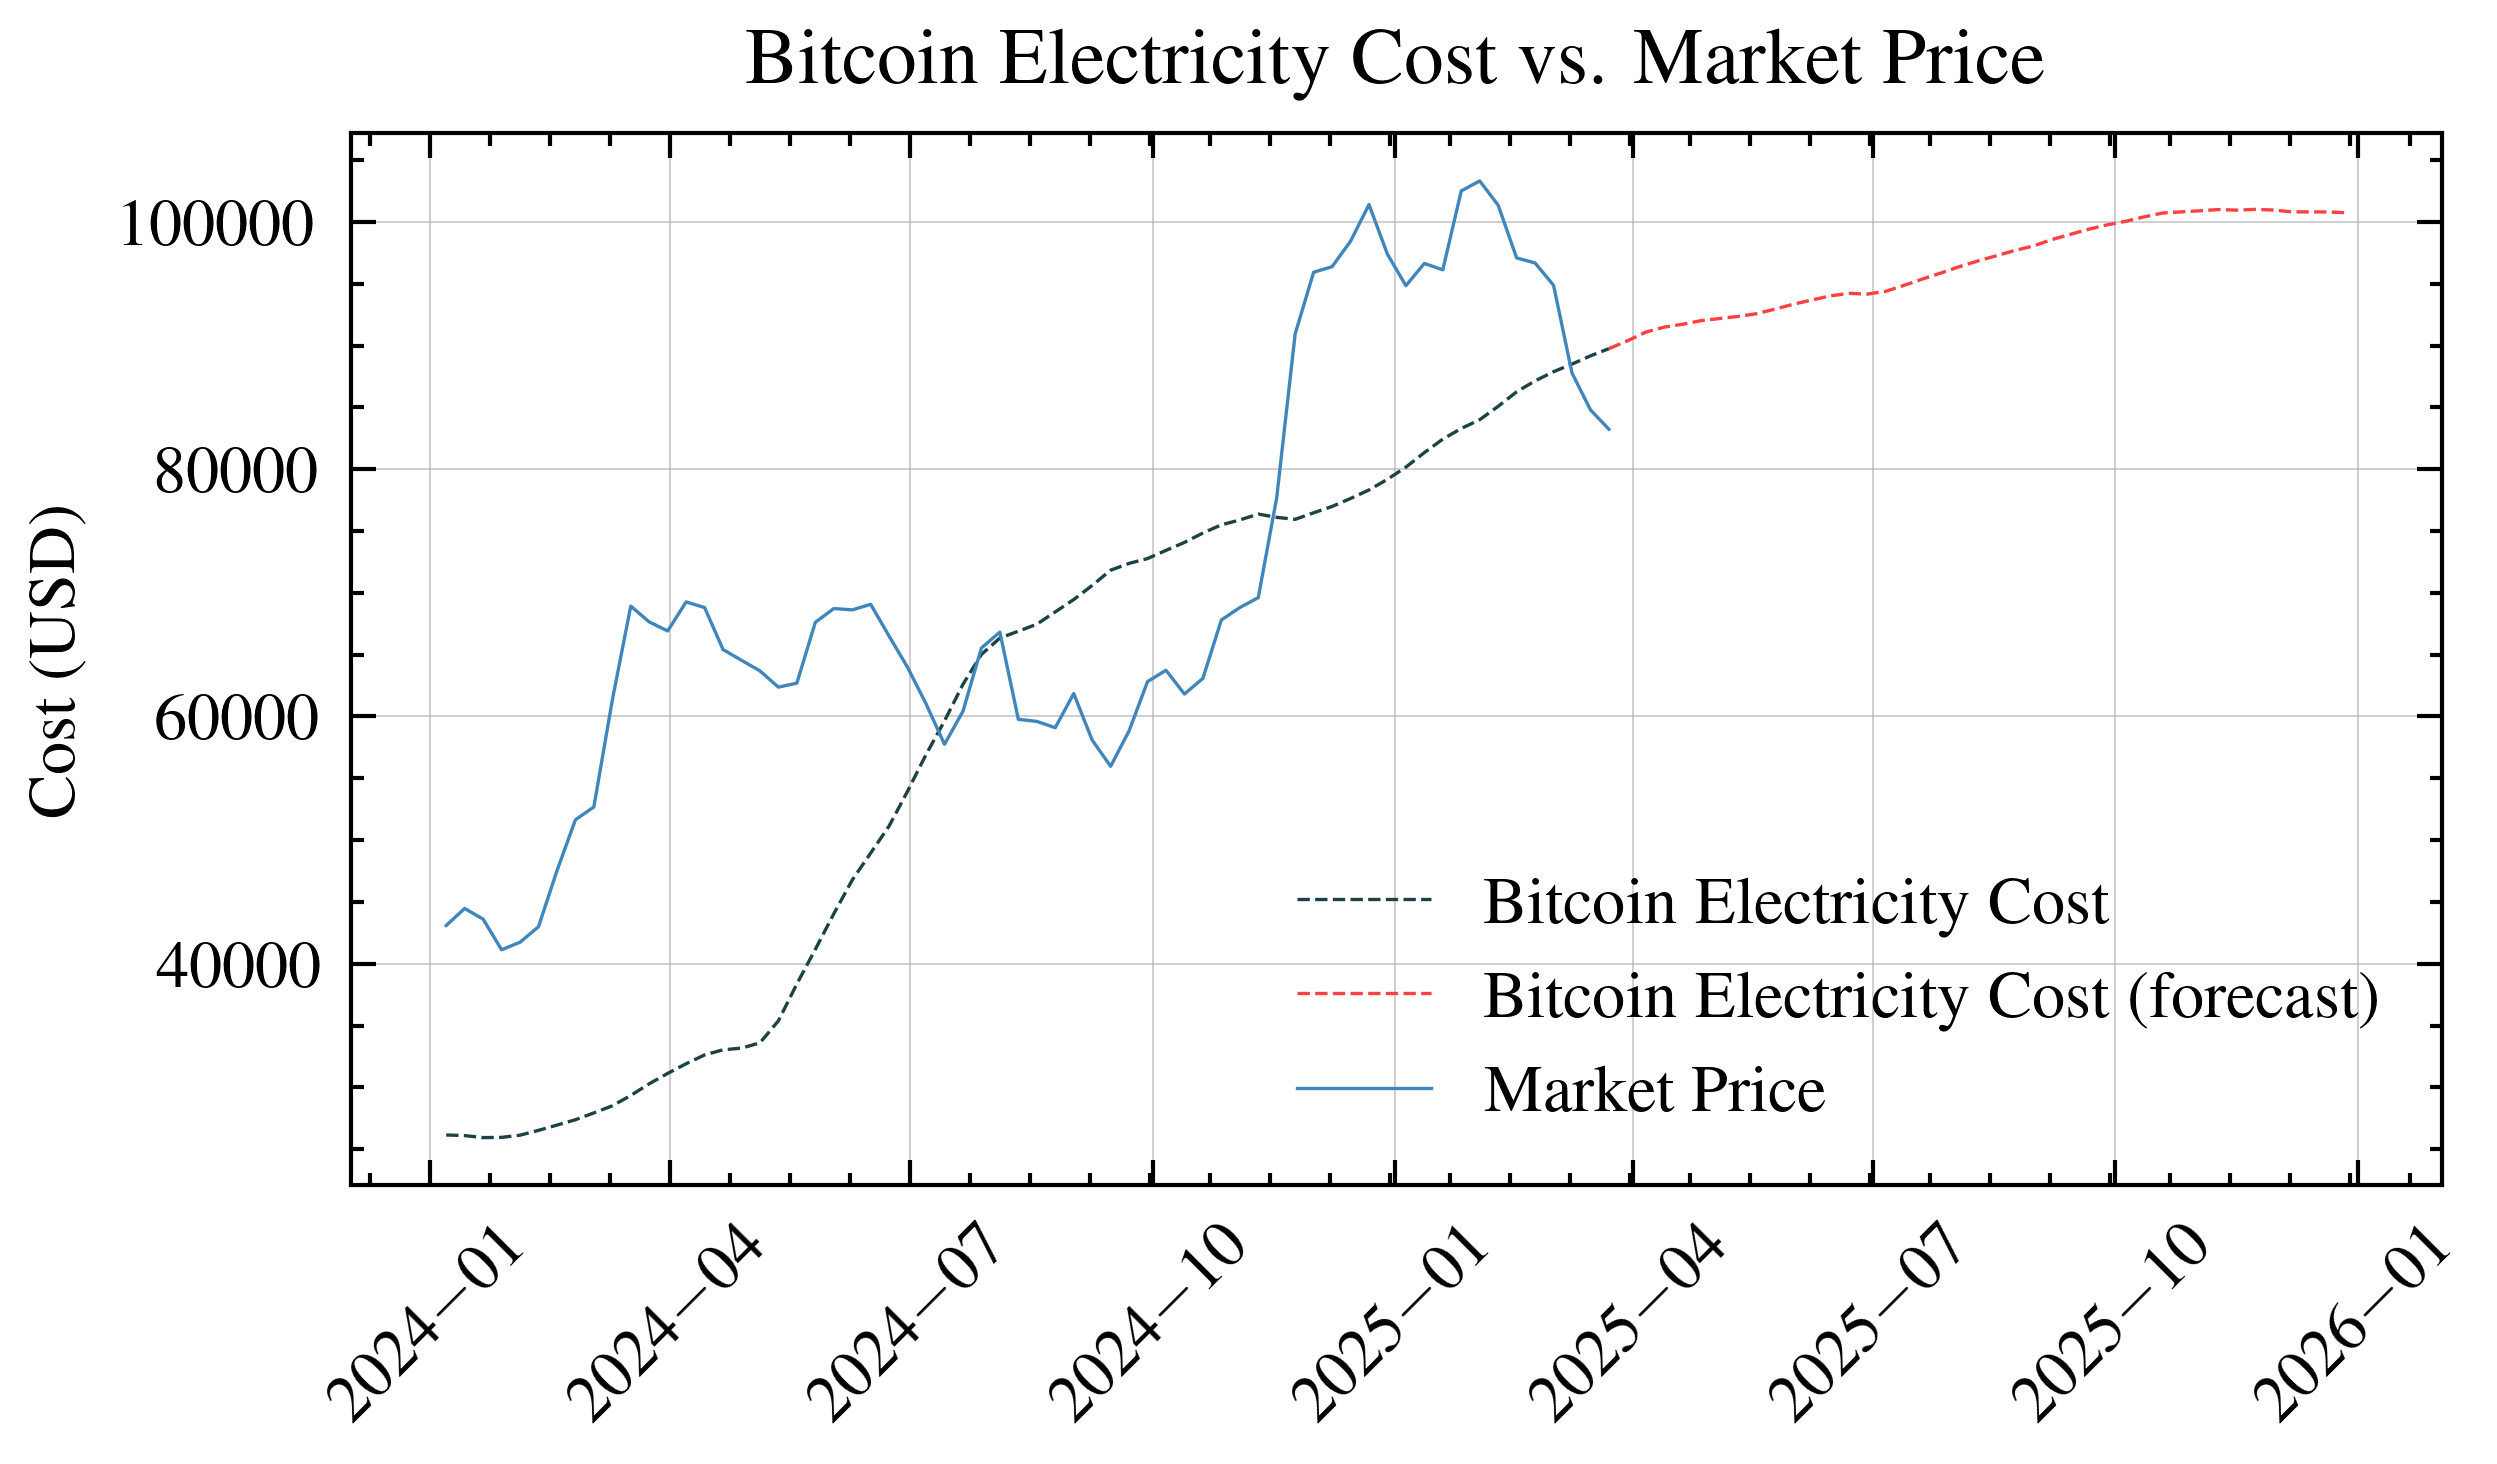

In [30]:
df_filtered = main_df['2024-01-01':'2026-01-01'].copy()
with plt.style.context(['science','ieee']):
    plt.figure(figsize=(4, 2.25))
    plt.grid(True, linestyle='-', alpha=0.7, linewidth=0.2)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.plot(df_filtered[:df.index[-1]].index, df_filtered[:df.index[-1]]['mining_cost'], label='Bitcoin Electricity Cost', color=LINE_COLOR, linestyle='--', linewidth=0.4)
    plt.plot(df_filtered[df.index[-1]:].index, df_filtered[df.index[-1]:]['mining_cost'], label='Bitcoin Electricity Cost (forecast)', color=LINE_COLOR_RED, linestyle='--', linewidth=0.4)
    plt.plot(df_filtered.index, df_filtered['market_price'], label='Market Price',color=LINE_COLOR_BLUE,  linestyle='-', linewidth=0.4)
#    plt.plot(df_filtered.index, df_filtered['stock_to_flow'], label='Stock To Flow',color=LINE_COLOR_GREEN,  linestyle='-', linewidth=0.4)
    plt.ylabel('Cost (USD)')
    plt.title('Bitcoin Electricity Cost vs. Market Price')
    plt.legend()
    plt.savefig(ASSETS+'miningcostforecast5.png')
    plt.show()

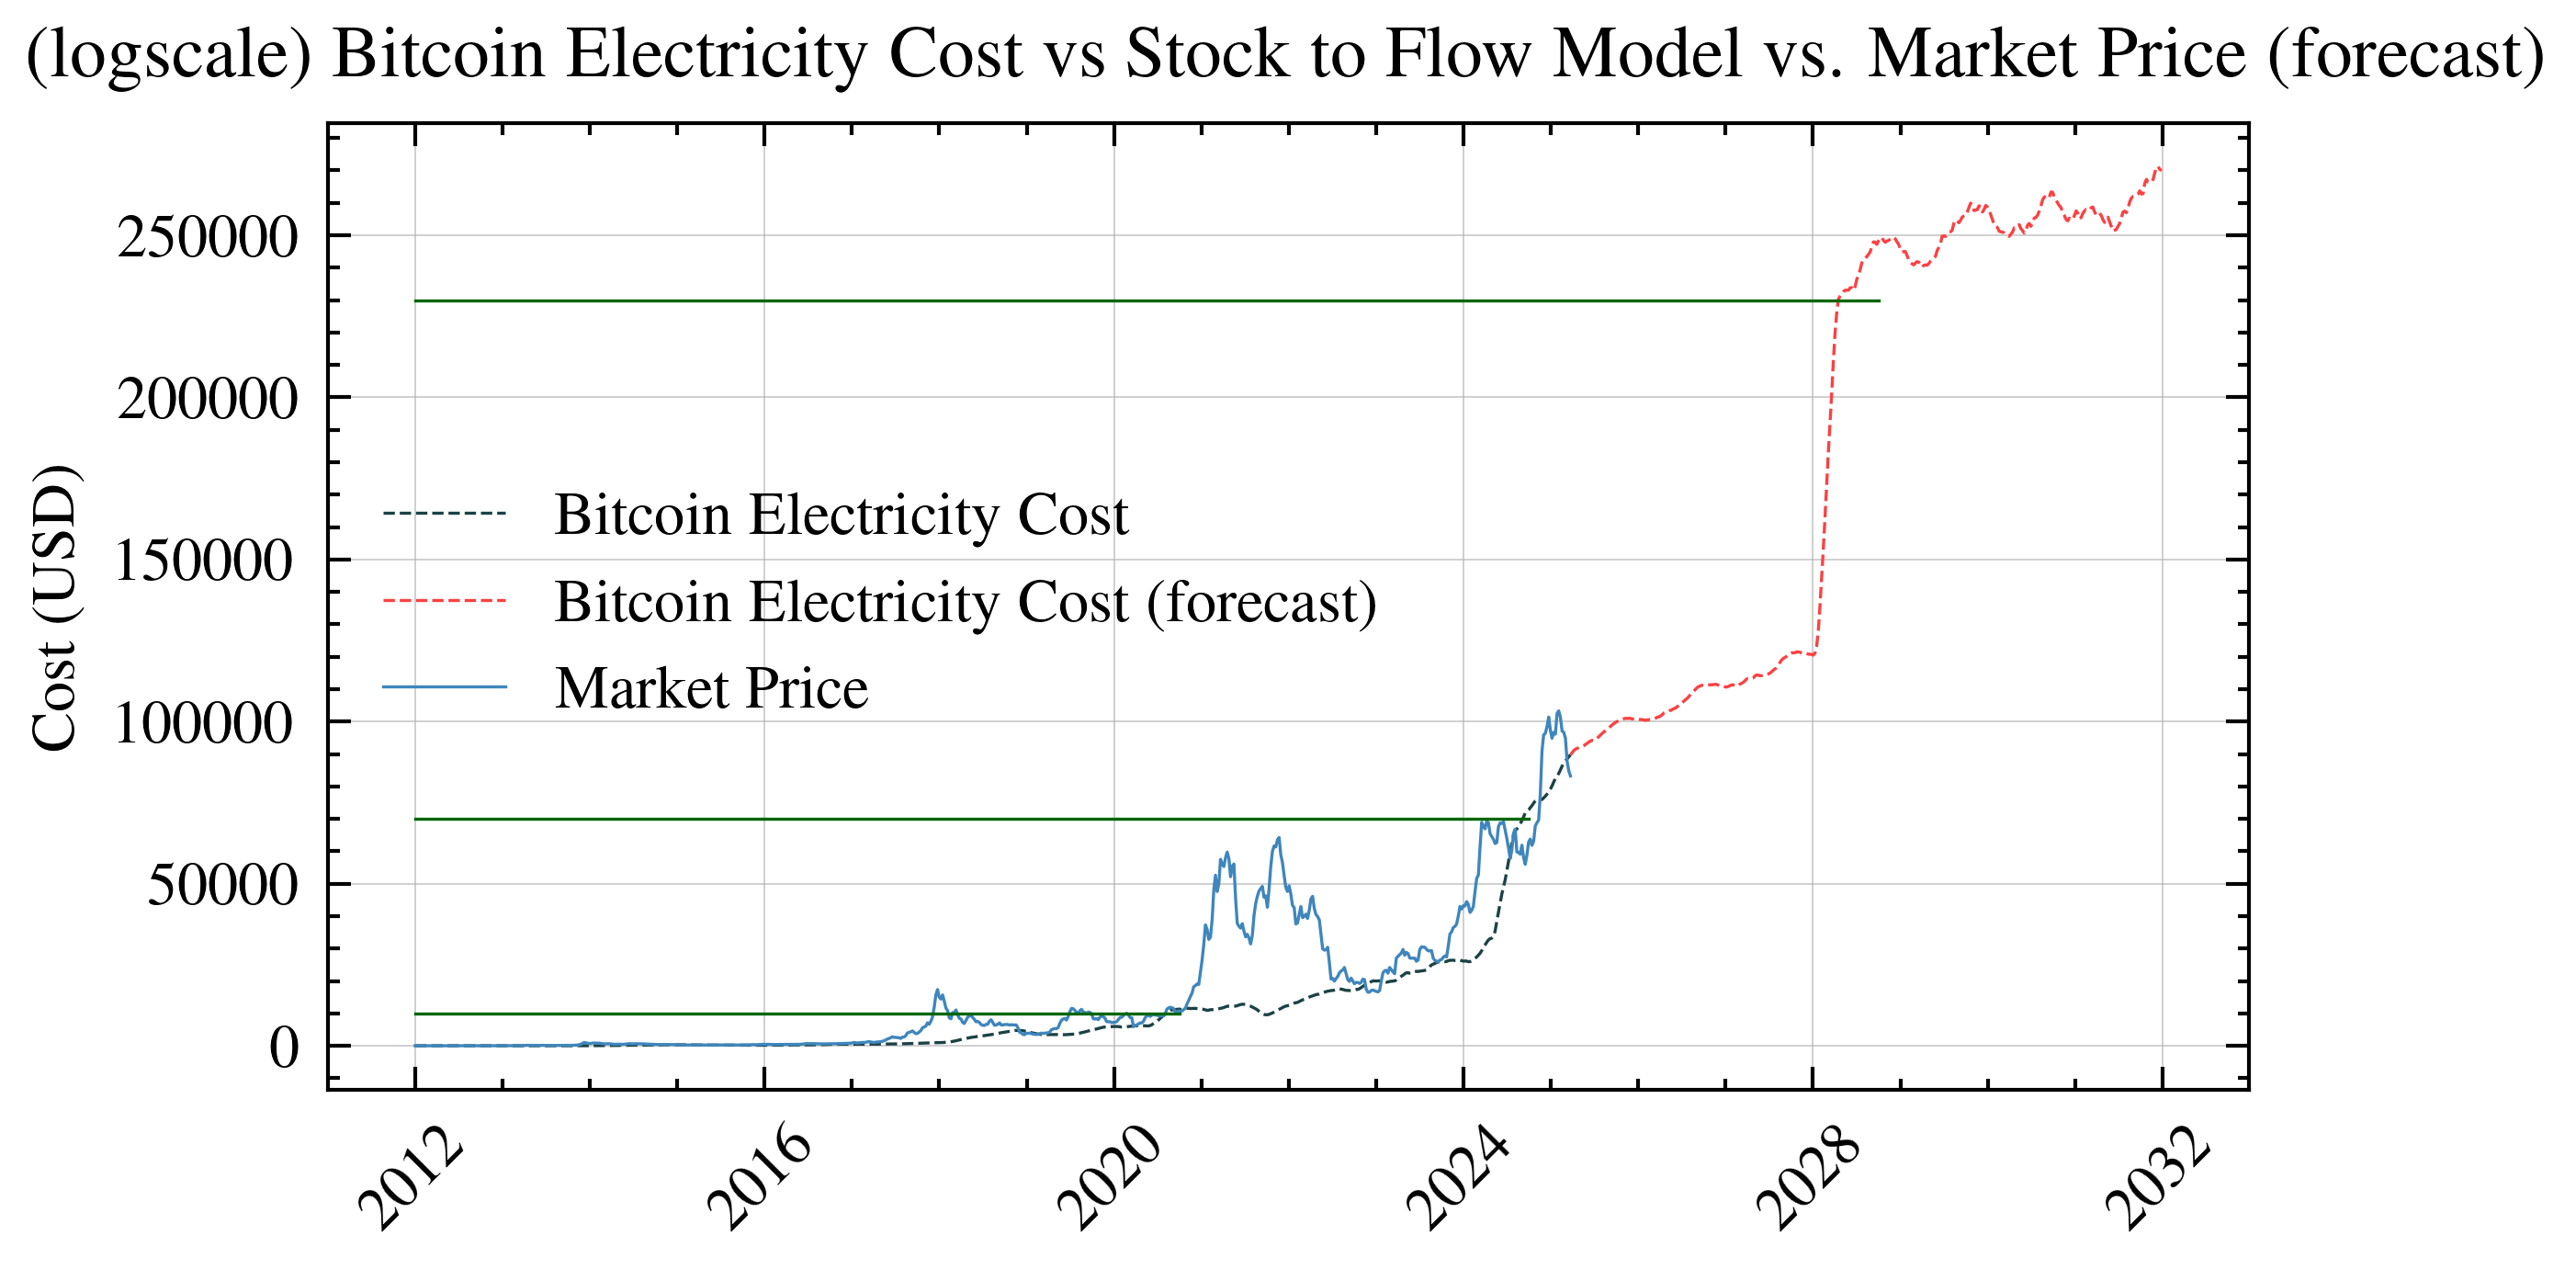

In [64]:
df_filtered = main_df['2012-01-01':'2032-01-01'].copy()
with plt.style.context(['science','ieee']):
    plt.figure(figsize=(4, 2.25))
    plt.grid(True, linestyle='-', alpha=0.7, linewidth=0.2)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.plot(df_filtered[:df.index[-1]].index, df_filtered[:df.index[-1]]['mining_cost'], label='Bitcoin Electricity Cost', color=LINE_COLOR, linestyle='--', linewidth=0.4)
    plt.plot(df_filtered[df.index[-1]:].index, df_filtered[df.index[-1]:]['mining_cost'], label='Bitcoin Electricity Cost (forecast)', color=LINE_COLOR_RED, linestyle='--', linewidth=0.4)
    plt.plot(df_filtered.index, df_filtered['market_price'], label='Market Price',color=LINE_COLOR_BLUE,  linestyle='-', linewidth=0.4)
#    plt.plot(df_filtered.index, df_filtered['stock_to_flow'], label='Stock To Flow',color=LINE_COLOR_GREEN,  linestyle='-.', linewidth=0.4)
    plt.plot([pd.to_datetime('2012-01-01'),pd.to_datetime('2024-10-01')], [70000,70000], color=LINE_COLOR_GREEN,  linestyle='-', linewidth=0.4)
    plt.plot([pd.to_datetime('2012-01-01'),pd.to_datetime('2020-10-01')], [10000,10000], color=LINE_COLOR_GREEN,  linestyle='-', linewidth=0.4)
    plt.plot([pd.to_datetime('2012-01-01'),pd.to_datetime('2028-10-01')], [230000,230000], color=LINE_COLOR_GREEN,  linestyle='-', linewidth=0.4)
    plt.ylabel('Cost (USD)')
    plt.title('(logscale) Bitcoin Electricity Cost vs Stock to Flow Model vs. Market Price (forecast)')
    plt.legend()
    plt.savefig(ASSETS+'miningcostforecaststf2.png')
    plt.show()